#Importing Packages and Data

In [282]:
# Data processing libraries
import gdown
import pandas as pd
import numpy as np
import sys
import time

# Just to ignore deprecation warning and stuffs
import warnings
warnings.filterwarnings('ignore')

# Progress bar on for loops
from tqdm import tqdm

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Error metric ready to use function
from sklearn.metrics import mean_squared_error as mse

# Utility functions for evaluating models
from sklearn.model_selection import (
    KFold,
    train_test_split as tts,
    cross_val_score as cvs,
    cross_val_predict as cvp,
)

# Zoo of models
from sklearn import ensemble, linear_model
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

!pip3 install catboost
import catboost as cb
from catboost import CatBoostRegressor

# Feature impact visualization
try:
  import shap
  from sklearn.inspection import permutation_importance
except:
  !pip3 install shap
  import shap
  from sklearn.inspection import permutation_importance

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [283]:
#Download Data Drive

url_train = "https://drive.google.com/uc?id=1z2A7TNHutbRa5dleDCF8Xu0sUfVnijIr"

path_train = '/content/data_train.csv'

url_test = "https://drive.google.com/uc?id=1ITxTokWQY-g4EhgXVi3kLwpWjITTinob"

path_test = '/content/data_test.csv'

try:
  df_train = pd.read_csv(path_train)
  df_test = pd.read_csv(path_test)

except:
  gdown.download(url_train, path_train, quiet=False)
  gdown.download(url_test, path_test, quiet=False)
  df_train = pd.read_csv(path_train)
  df_test = pd.read_csv(path_test)

---
#**Below is the EDA Zone, Beware of Wild Animals**
---



#Pre-Processing (Fav)

##Tis a Function

###Box Plot Function

In [284]:
def box_plot_cat(df, x_value, y_value=None, rot=0, show_mean_lines_mean=False, show_mean_lines_upper=False, show_mean_font=False, line_color='r', title: str = None):
    sns.set(style="whitegrid")

    '''
    Berguna untuk membuat box plot 1 atau 2 dimensi.


    df untuk dataframe yang akan digunakan untuk plot.
    x_value untuk nama kolom numerik yang akan digunakan untuk box plot pada 1 dimensi atau kategorik di x-axis untuk 2 dimensi.
    y_value untuk nama kolom numerik yang akan digunakan untuk box plot pada 2 dimensi.
    rot untuk rotation dari label x.
    show_mean_lines_mean memberikan pilihan menampilkan mean dari setiap box plot.
    show_mean_lines_upper memberikan pilihan menampilkan mean+2std (indikator outlier) pada setiap box plot.
    '''

    if y_value:
        # Create the box plot
        ax = sns.boxplot(data=df, x=x_value, y=y_value)

        # Wider Plot
        plt.gcf().set_size_inches(12, 6)

        # Rotation of x-labels
        plt.xticks(rotation=rot)

        if show_mean_lines_mean:
            # Calculate means for each category
            means = df.groupby(x_value)[y_value].mean()
            x_labels = df[x_value].unique()
            for x, label in enumerate(ax.get_xticklabels()):
                category = label.get_text()
                y = means[category]

                # Add horizontal line for the mean in the corresponding box plot
                ax.axhline(y=y, color=line_color, linestyle='--', lw=2, xmin=x/len(x_labels), xmax=(x+1)/len(x_labels))

        if show_mean_lines_upper:
            # Calculate means for each category
            means = df.groupby(x_value)[y_value].mean()
            x_labels = df[x_value].unique()
            for x, label in enumerate(ax.get_xticklabels()):
                category = label.get_text()
                y = means[category]

                # Calculate upper mean + 2s
                upper_mean = y + 2 * df.groupby(x_value)[y_value].std()[category]

                # Add horizontal line for upper mean + 2s in the corresponding box plot
                ax.axhline(y=upper_mean, color=line_color, linestyle='--', lw=2, xmin=x/len(x_labels), xmax=(x+1)/len(x_labels))

        if show_mean_font:
            # Calculate means for each category
            means = df.groupby(x_value)[y_value].mean()
            x_labels = df[x_value].unique()
            for x, label in enumerate(ax.get_xticklabels()):
                category = label.get_text()
                y = means[category]

                # Display the mean value at the very top
                plt.text(x, max(df[y_value]) + 0.02, f'{y:.2f}', ha='center', va='bottom', color=line_color, fontsize=10)

        # Show the plot
        plt.title(title)
        plt.show()

    else:
        ax = sns.boxplot(data=df, x=x_value)

        # Calculate the mean and std
        mean = df[x_value].mean()
        std = df[x_value].std()

        # Wider Plot
        plt.gcf().set_size_inches(12, 6)

        # Rotation of x-labels
        plt.xticks(rotation=rot)

        # Calculate the outlier cutoff
        cutoff = mean + 2 * std

        # Count the number of outliers
        outliers_count = (df[x_value] > cutoff).sum()

        # Print the number of outliers
        print(f'Number of outliers above Mean + 2s: {outliers_count}')

        if show_mean_lines_mean:
            # Add vertical line for the mean
            ax.axvline(x=mean, color=line_color, linestyle='--', label=f'Mean', lw=2)

        if show_mean_lines_upper:
            # Calculate upper mean + 2s
            upper_mean = mean + 2 * std

            # Calculate the position for the vertical line
            x_position = upper_mean  # Center of the box plot

            # Add vertical line for upper mean + 2s
            ax.axvline(x=x_position, color=line_color, linestyle='--', lw=2)

        # Add a title
        plt.title(title)

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()

##Inspecting the Data

In [285]:
df_train.shape

(20355, 15)

In [286]:
df_train.dtypes

timestamp         object
api_calls        float64
clouds           float64
distance_max     float64
distance_mean    float64
distance_min     float64
humidity         float64
price_mean       float64
rain             float64
surge_max        float64
surge_mean       float64
surge_min        float64
temp             float64
wind             float64
type               int64
dtype: object

In [287]:
df_train.head()

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,1.055556,1.0,40.627333,1.350667,0
1,2018-11-26 07:00:00,10.0,0.970000,2.67,1.690000,1.09,0.920000,17.300000,0.0,2.00,1.100000,1.0,41.137500,1.735000,0
2,2018-11-26 08:00:00,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.500000,0.0,1.00,1.000000,1.0,40.920000,1.330000,0
3,2018-11-26 09:00:00,11.0,1.000000,3.08,1.920909,1.39,0.927500,17.954545,0.0,1.75,1.113636,1.0,40.937500,1.365000,0
4,2018-11-26 10:00:00,12.0,0.995000,3.01,2.122500,1.07,0.940000,18.625000,0.0,1.50,1.083333,1.0,40.695000,1.895000,0


In [288]:
df_train['surge_min'].unique()

array([1.  , 1.5 , 1.25])

In [289]:
df_train.isna().sum()

timestamp          0
api_calls          0
clouds           192
distance_max       0
distance_mean      0
distance_min       0
humidity         192
price_mean         0
rain             192
surge_max          0
surge_mean         0
surge_min          0
temp             192
wind             192
type               0
dtype: int64

In [290]:
df_test

,index,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,surge_min,temp,wind,type
0,0,2018-12-14 00:00:00,13.0,0.69,3.02,1.980000,1.06,0.68,0.0,2.00,1.115385,1.0,29.93,1.99,0
1,1,2018-12-14 01:00:00,14.0,0.77,2.34,1.541429,1.04,0.68,0.0,1.00,1.000000,1.0,30.19,2.35,0
2,2,2018-12-14 02:00:00,13.0,0.59,3.00,2.010769,1.08,0.69,0.0,1.50,1.096154,1.0,30.02,1.98,0
3,3,2018-12-14 03:00:00,12.0,0.68,3.14,1.860833,1.06,0.70,0.0,1.25,1.020833,1.0,29.89,1.92,0
4,4,2018-12-14 04:00:00,7.0,0.72,2.41,1.634286,1.06,0.71,0.0,1.25,1.035714,1.0,29.92,1.58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11035,11035,2018-12-18 14:00:00,11.0,0.48,3.08,2.024545,0.72,0.47,0.0,1.00,1.000000,1.0,26.19,13.89,95
11036,11036,2018-12-18 15:00:00,16.0,0.34,3.20,2.002500,0.72,0.46,0.0,1.00,1.000000,1.0,27.22,15.03,95
11037,11037,2018-12-18 16:00:00,7.0,0.31,3.08,2.105714,0.72,0.47,0.0,1.00,1.000000,1.0,28.70,14.60,95
11038,11038,2018-12-18 17:00:00,8.0,0.15,3.20,1.952500,0.72,0.46,0.0,1.00,1.000000,1.0,30.05,13.55,95


In [291]:
print(df_test.columns)
print(df_train.columns)

Index(['index', 'timestamp', 'api_calls', 'clouds', 'distance_max',
       'distance_mean', 'distance_min', 'humidity', 'rain', 'surge_max',
       'surge_mean', 'surge_min', 'temp', 'wind', 'type'],
      dtype='object')
Index(['timestamp', 'api_calls', 'clouds', 'distance_max', 'distance_mean',
       'distance_min', 'humidity', 'price_mean', 'rain', 'surge_max',
       'surge_mean', 'surge_min', 'temp', 'wind', 'type'],
      dtype='object')


In [292]:
df_merged = pd.concat([df_train,df_test])

In [293]:
df_merged

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,index
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,1.055556,1.0,40.627333,1.350667,0,NaN
1,2018-11-26 07:00:00,10.0,0.970000,2.67,1.690000,1.09,0.920000,17.300000,0.0,2.00,1.100000,1.0,41.137500,1.735000,0,NaN
2,2018-11-26 08:00:00,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.500000,0.0,1.00,1.000000,1.0,40.920000,1.330000,0,NaN
3,2018-11-26 09:00:00,11.0,1.000000,3.08,1.920909,1.39,0.927500,17.954545,0.0,1.75,1.113636,1.0,40.937500,1.365000,0,NaN
4,2018-11-26 10:00:00,12.0,0.995000,3.01,2.122500,1.07,0.940000,18.625000,0.0,1.50,1.083333,1.0,40.695000,1.895000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11035,2018-12-18 14:00:00,11.0,0.480000,3.08,2.024545,0.72,0.470000,NaN,0.0,1.00,1.000000,1.0,26.190000,13.890000,95,11035.0
11036,2018-12-18 15:00:00,16.0,0.340000,3.20,2.002500,0.72,0.460000,NaN,0.0,1.00,1.000000,1.0,27.220000,15.030000,95,11036.0
11037,2018-12-18 16:00:00,7.0,0.310000,3.08,2.105714,0.72,0.470000,NaN,0.0,1.00,1.000000,1.0,28.700000,14.600000,95,11037.0
11038,2018-12-18 17:00:00,8.0,0.150000,3.20,1.952500,0.72,0.460000,NaN,0.0,1.00,1.000000,1.0,30.050000,13.550000,95,11038.0


##Data Types

In [294]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

In [295]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_merged['type'] = df_merged['type'].astype('category')

In [296]:
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test['type'] = df_test['type'].astype('category')

##Simple Linear Correlation Between Numerical Variables

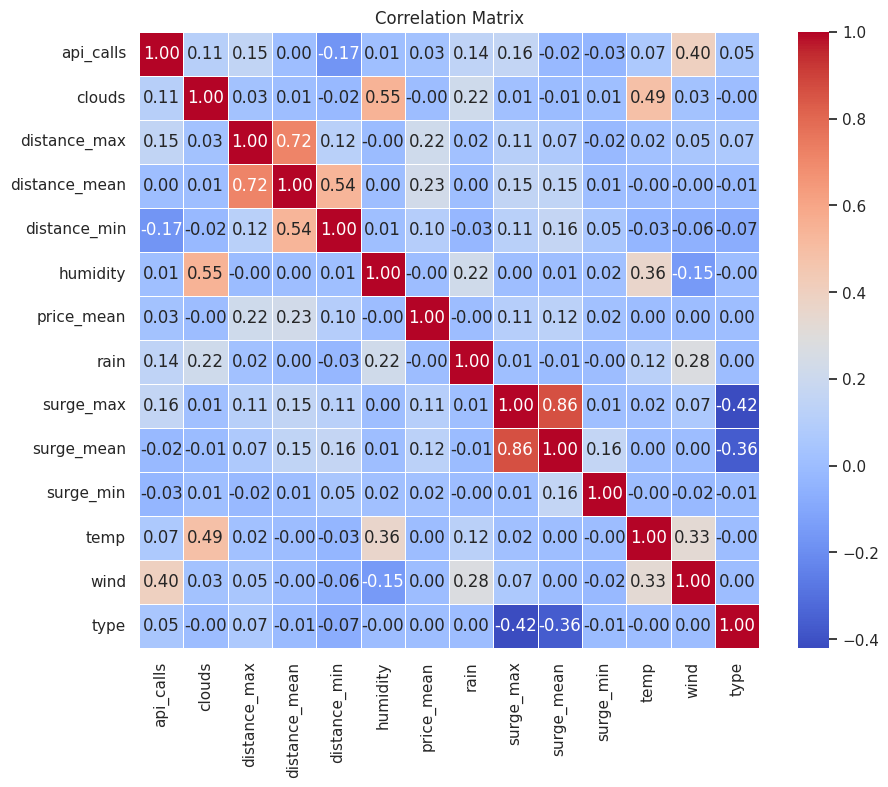

In [297]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

##Columns for Date

In [298]:
df_train['year'] = df_train['timestamp'].dt.year

df_train['month'] = df_train['timestamp'].dt.month

df_train['day'] = df_train['timestamp'].dt.day

df_train['hour'] = df_train['timestamp'].dt.hour

df_train['day_of_week'] = df_train['timestamp'].dt.dayofweek + 1

In [299]:
df_test['year'] = df_test['timestamp'].dt.year

df_test['month'] = df_test['timestamp'].dt.month

df_test['day'] = df_test['timestamp'].dt.day

df_test['hour'] = df_test['timestamp'].dt.hour

df_test['day_of_week'] = df_test['timestamp'].dt.dayofweek + 1

In [300]:
df_train.head()

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,year,month,day,hour,day_of_week
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,1.055556,1.0,40.627333,1.350667,0,2018,11,26,6,1
1,2018-11-26 07:00:00,10.0,0.970000,2.67,1.690000,1.09,0.920000,17.300000,0.0,2.00,1.100000,1.0,41.137500,1.735000,0,2018,11,26,7,1
2,2018-11-26 08:00:00,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.500000,0.0,1.00,1.000000,1.0,40.920000,1.330000,0,2018,11,26,8,1
3,2018-11-26 09:00:00,11.0,1.000000,3.08,1.920909,1.39,0.927500,17.954545,0.0,1.75,1.113636,1.0,40.937500,1.365000,0,2018,11,26,9,1
4,2018-11-26 10:00:00,12.0,0.995000,3.01,2.122500,1.07,0.940000,18.625000,0.0,1.50,1.083333,1.0,40.695000,1.895000,0,2018,11,26,10,1


In [301]:
df_train['day_of_week'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [302]:
df_train['year'].unique()

array([2018])

In [303]:
df_train['month'].unique()

array([11, 12])

In [304]:
df_train['day'].unique()

array([26, 27, 28, 29, 30,  1,  2,  3,  4,  9, 10, 13])

In [305]:
df_train['hour'].unique()

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23,  0,  1,  2,  3,  4,  5])

In [306]:
df_train.drop(['year'], axis=1, inplace=True)

In [307]:
df_train.head(1)

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.5,1.055556,1.0,40.627333,1.350667,0,11,26,6,1


##Visualization for Distribution, Trends, and Tendency

###Distribution

<Figure size 900x800 with 0 Axes>

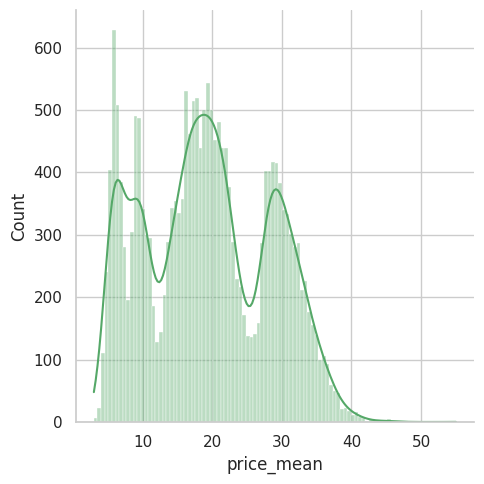

In [308]:
plt.figure(figsize=(9, 8))
sns.displot(df_train['price_mean'], color='g', bins=100, alpha=0.4, kde=True);

In [309]:
#df_num = df_train.select_dtypes(include = ['float64', 'int64'])
#df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

###Trends

####Trend of Time

#####Outlier

In [310]:
#plt.figure(figsize=(20, 8))
#sns.lineplot(x=df_train['timestamp'], y=df_train['price_mean'], color='red', marker='o')
#plt.xticks(rotation=45)
#plt.show()

In [311]:
df_train.nsmallest(10, 'price_mean')

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week
12980,2018-11-28 07:00:00,1.0,0.240769,1.28,1.280000,1.28,0.795385,3.000000,0.0,1.0,1.0,1.0,34.936923,6.332308,61,11,28,7,3
13362,2018-11-26 08:00:00,1.0,0.986667,1.43,1.430000,1.43,0.933333,3.000000,0.0,1.0,1.0,1.0,40.723333,1.313333,63,11,26,8,1
14041,2018-11-28 01:00:00,4.0,NaN,1.85,1.370000,1.14,NaN,3.375000,NaN,1.0,1.0,1.0,NaN,NaN,66,11,28,1,3
13967,2018-12-04 01:00:00,6.0,0.040000,2.38,1.171667,0.69,0.600000,3.416667,0.0,1.0,1.0,1.0,45.720000,7.860000,65,12,4,1,2
13404,2018-11-28 08:00:00,1.0,0.521667,4.35,4.350000,4.35,0.801667,3.500000,0.0,1.0,1.0,1.0,34.526667,5.526667,63,11,28,8,3
14824,2018-12-10 01:00:00,1.0,0.220000,0.69,0.690000,0.69,0.610000,3.500000,0.0,1.0,1.0,1.0,27.750000,4.340000,69,12,10,1,1
13983,2018-12-13 09:00:00,6.0,0.390000,1.93,1.113333,0.54,0.640000,3.583333,0.0,1.0,1.0,1.0,20.060000,3.920000,65,12,13,9,4
13829,2018-11-28 07:00:00,4.0,0.240000,1.20,0.687500,0.42,0.793846,3.625000,0.0,1.0,1.0,1.0,34.995385,6.379231,65,11,28,7,3
13943,2018-12-03 01:00:00,11.0,0.990000,1.36,1.081818,0.64,0.930000,3.636364,0.0,1.0,1.0,1.0,47.750000,1.890000,65,12,3,1,1
13985,2018-12-13 11:00:00,7.0,0.450000,2.38,1.204286,0.68,0.630000,3.642857,0.0,1.0,1.0,1.0,20.260000,2.900000,65,12,13,11,4


In [312]:
df_train[(df_train['day']==10) & (df_train['month']==12)].sample(10)

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week
11005,2018-12-10 02:00:00,7.0,0.2625,4.36,2.964286,1.51,0.6000,17.642857,0.0,1.25,1.035714,1.0,28.6800,4.9900,51,12,10,2,1
4643,2018-12-10 00:00:00,4.0,0.1100,2.57,1.815000,1.15,0.6100,21.750000,0.0,1.00,1.000000,1.0,28.7800,5.1900,21,12,10,0,1
190,2018-12-10 02:00:00,11.0,0.2650,2.48,1.750909,1.07,0.5975,18.090909,0.0,2.00,1.113636,1.0,28.8575,5.0850,0,12,10,2,1
14823,2018-12-10 00:00:00,7.0,0.1100,3.13,1.872857,0.56,0.6100,5.928571,0.0,1.00,1.000000,1.0,28.7800,5.1900,69,12,10,0,1
14400,2018-12-10 02:00:00,6.0,0.2675,3.32,2.290000,0.72,0.6000,6.333333,0.0,1.00,1.000000,1.0,28.8125,5.1825,67,12,10,2,1
11216,2018-12-10 02:00:00,12.0,0.2700,5.38,2.590833,0.43,0.6000,15.791667,0.0,1.25,1.020833,1.0,28.8500,5.1900,52,12,10,2,1
8036,2018-12-10 01:00:00,2.0,0.2200,2.39,1.860000,1.33,0.5800,9.000000,0.0,1.25,1.125000,1.0,29.2400,4.2900,37,12,10,1,1
18216,2018-12-10 00:00:00,3.0,0.1100,2.56,2.453333,2.32,0.5800,30.333333,0.0,1.00,1.000000,1.0,30.1500,5.1200,85,12,10,0,1
15885,2018-12-10 00:00:00,3.0,0.1100,3.39,2.533333,1.17,0.5800,20.500000,0.0,1.00,1.000000,1.0,30.1500,4.9900,74,12,10,0,1
3159,2018-12-10 01:00:00,1.0,0.2000,1.52,1.520000,1.52,0.5800,16.500000,0.0,1.00,1.000000,1.0,29.2700,4.1400,14,12,10,1,1


Number of outliers above Mean + 2s: 1


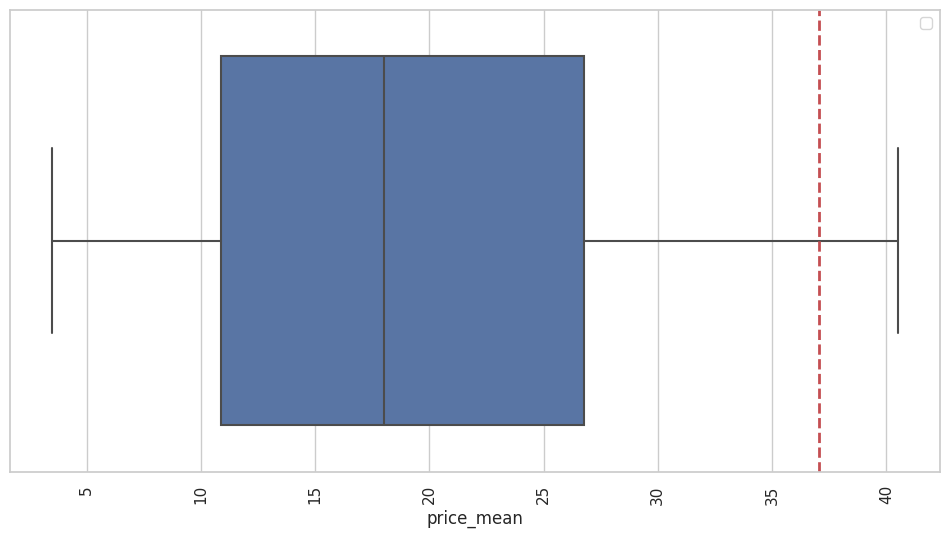

In [313]:
box_plot_cat(df=df_train[(df_train['day']==10) & (df_train['month']==12)], x_value='price_mean', rot=90, show_mean_lines_upper=True)

<Axes: xlabel='hour', ylabel='price_mean'>

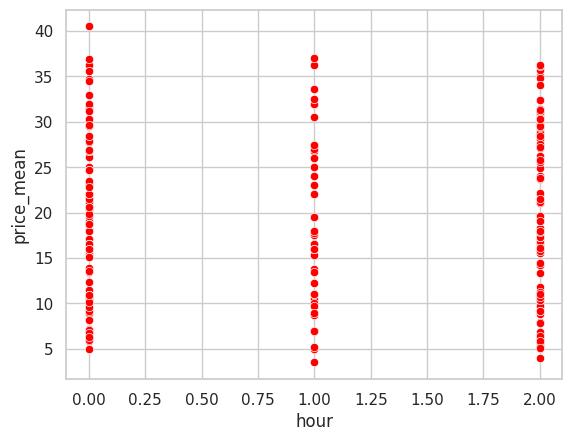

In [314]:
sns.scatterplot(x=df_train[(df_train['day']==10) & (df_train['month']==12)]['hour'], y=df_train['price_mean'], color='red')

In [315]:
df_train[(df_train['day']==10) & (df_train['month']==12)]['hour']

189      0
190      2
401      0
402      1
403      2
        ..
20121    1
20122    2
20331    0
20332    1
20333    2
Name: hour, Length: 253, dtype: int64

In [316]:
df_train.shape

(20355, 19)

----
GTW MAU APUS OUTLIER ATO GAK

In [317]:
df_train = df_train[(df_train['day']!=10) | (df_train['month']!=12)]
df_train.shape

(20102, 19)

In [318]:
'''
plt.figure(figsize=(20, 8))
sns.lineplot(x=df_train['timestamp'], y=df_train['price_mean'], color='red', marker='o')
plt.xticks(rotation=45)
plt.show()

'''

"\nplt.figure(figsize=(20, 8))\nsns.lineplot(x=df_train['timestamp'], y=df_train['price_mean'], color='red', marker='o')\nplt.xticks(rotation=45)\nplt.show()\n\n"

In [319]:
df_train['day'].unique()

array([26, 27, 28, 29, 30,  1,  2,  3,  4,  9, 13])

In [320]:
df_test['day'].unique()

array([14, 15, 16, 17, 18])

<Axes: xlabel='hour', ylabel='price_mean'>

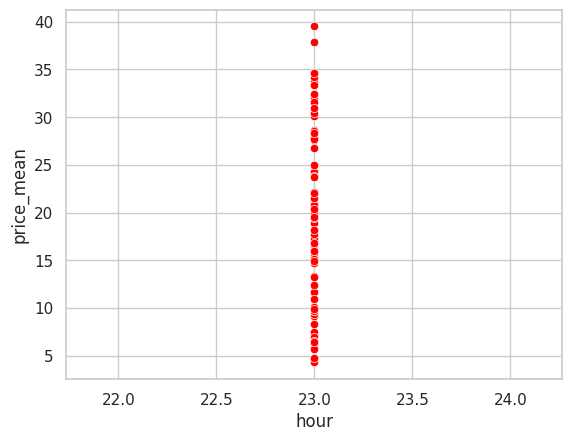

In [321]:
sns.scatterplot(x=df_train[(df_train['day']==9) & (df_train['month']==12)]['hour'], y=df_train['price_mean'], color='red')

In [322]:
df_train = df_train[(df_train['day']!=9) | (df_train['month']!=12)]
df_train.shape

(20006, 19)

#####Other

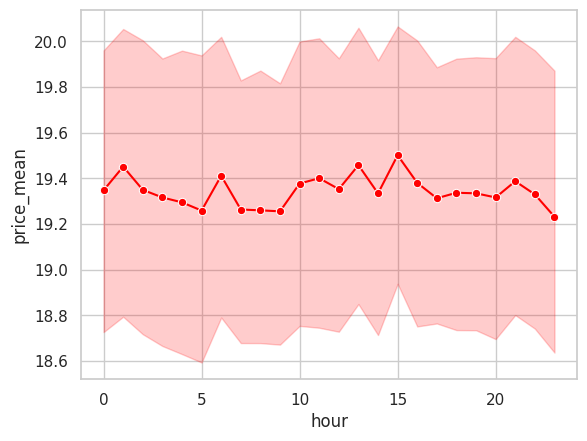

In [323]:
sns.lineplot(x=df_train['hour'], y=df_train['price_mean'], color='red', marker='o')
plt.show()

In [324]:
#sns.lineplot(x=df_train['day'], y=df_train['price_mean'], color='red', marker='o')
#plt.show()

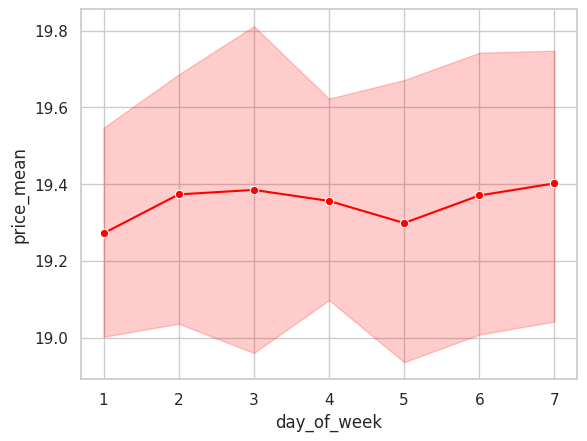

In [325]:
sns.lineplot(x=df_train['day_of_week'], y=df_train['price_mean'], color='red', marker='o')
plt.show()

In [326]:
#sns.lineplot(x=df_train['month'], y=df_train['price_mean'], color='red', marker='o')
#plt.show()

---
Cuma 2 Bulan Ternyata 😥

####Trend of Distance

In [327]:
#sns.scatterplot(x=df_train['distance_mean'], y=df_train['price_mean'], color='red')
#plt.show()

---
Harusnya ini paling relevan?

In [328]:
#sns.scatterplot(x=df_train['distance_max'], y=df_train['price_mean'], color='red')
#plt.show()

In [329]:
#sns.scatterplot(x=df_train['distance_min'], y=df_train['price_mean'], color='red')
#plt.show()

####Trend of Surge

In [330]:
#sns.scatterplot(x=df_train['surge_mean'], y=df_train['price_mean'], color='red')
#plt.show()

---
zero-inflated, tp di titik 1?

In [331]:
#sns.lineplot(x=df_train['surge_max'], y=df_train['price_mean'], color='red', marker='o')
#plt.show()

In [332]:
#sns.lineplot(x=df_train['surge_min'], y=df_train['price_mean'], color='red', marker='o')
#plt.show()

####Trend of Weather

In [333]:
#sns.scatterplot(x=df_train['clouds'], y=df_train['price_mean'], color='red')
#plt.show()

In [334]:
#sns.scatterplot(x=df_train['humidity'], y=df_train['price_mean'], color='red')
#plt.show()

In [335]:
#sns.scatterplot(x=df_train['rain'], y=df_train['price_mean'], color='red')
#plt.show()

---
Pertimbangkan ubah aja ke 0 dan 1 untuk hujan dengan tidak hujan

In [336]:
#sns.scatterplot(x=df_train['temp'], y=df_train['price_mean'], color='red')
#plt.show()

---
Clustering juga?

In [337]:
#sns.scatterplot(x=df_train['wind'], y=df_train['price_mean'], color='red')
#plt.show()

---
Ini clustering juga?

##Checking for Outliers and Anomalies

###Outliers

In [338]:
df_train.describe()

,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week
count,20006.000000,19814.000000,20006.00000,20006.000000,20006.000000,19814.000000,20006.000000,19814.000000,20006.000000,20006.000000,20006.000000,19814.000000,19814.000000,20006.000000,20006.000000,20006.000000,20006.000000,20006.000000
mean,14.207988,0.639807,3.57582,2.184923,1.009765,0.749250,19.344649,0.006119,1.203139,1.023394,1.000137,39.542601,5.949875,47.479306,11.479856,16.758273,11.815505,3.701889
std,7.127382,0.333560,1.10851,0.606090,0.494026,0.138124,8.942249,0.029819,0.322339,0.043110,0.007286,7.067656,3.502918,27.708943,0.499607,12.266684,6.832088,2.003821
min,1.000000,0.000000,0.03000,0.030000,0.020000,0.460000,3.000000,0.000000,1.000000,1.000000,1.000000,19.620000,0.300000,0.000000,11.000000,1.000000,0.000000,1.000000
25%,10.000000,0.390000,2.74250,1.768576,0.580000,0.630000,11.541667,0.000000,1.000000,1.000000,1.000000,36.070000,2.920000,23.000000,11.000000,3.000000,6.000000,2.000000
50%,13.000000,0.730000,3.30000,2.130000,1.000000,0.730000,19.000000,0.000000,1.000000,1.000000,1.000000,40.508667,5.100000,47.000000,11.000000,26.000000,12.000000,4.000000
75%,17.000000,0.956250,4.42000,2.641861,1.350000,0.890000,27.384615,0.000000,1.250000,1.031250,1.000000,44.215000,9.240000,71.000000,12.000000,28.000000,18.000000,5.000000
max,53.000000,1.000000,7.50000,6.090000,6.090000,0.990000,55.000000,0.359825,3.000000,1.535714,1.500000,55.410000,16.570000,95.000000,12.000000,30.000000,23.000000,7.000000


Number of outliers above Mean + 2s: 288


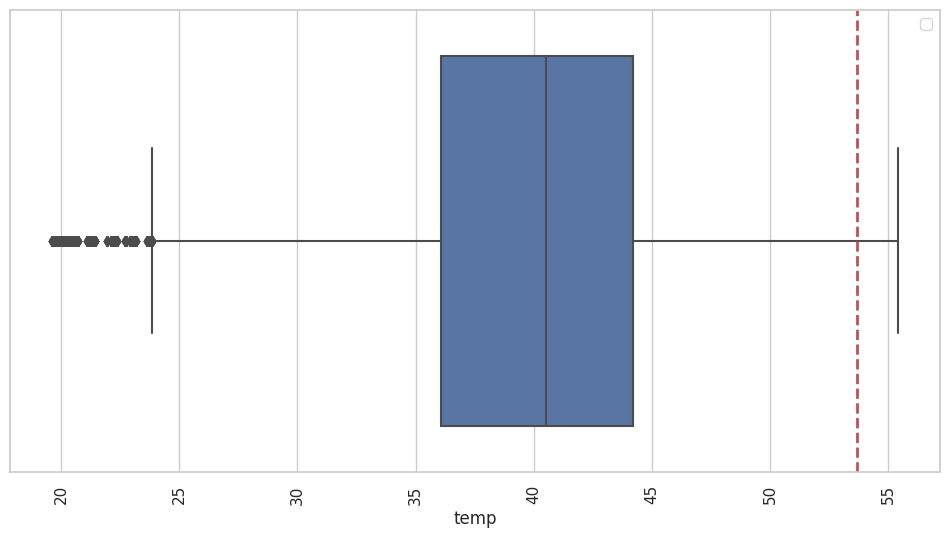

In [339]:
box_plot_cat(df=df_train, x_value='temp', rot=90, show_mean_lines_upper=True)

Number of outliers above Mean + 2s: 222


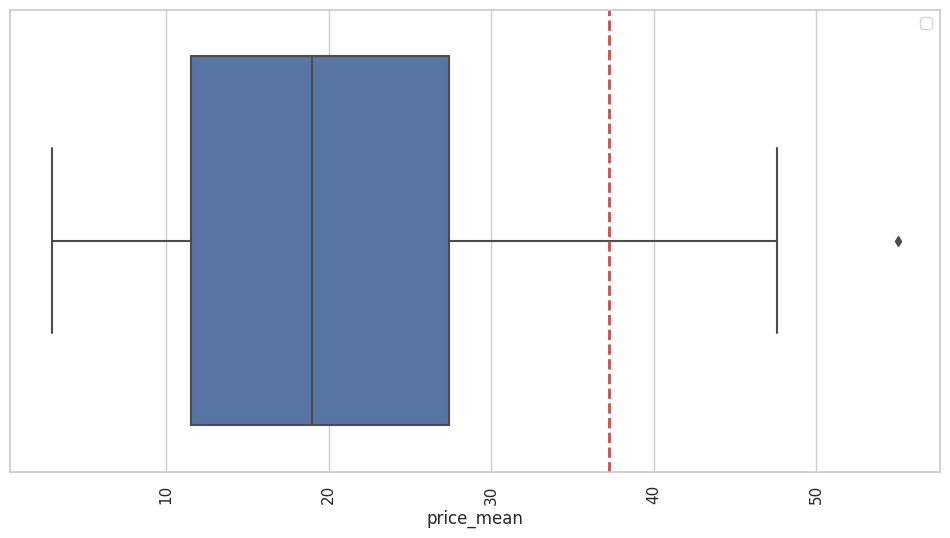

In [340]:
box_plot_cat(df=df_train, x_value='price_mean', rot=90, show_mean_lines_upper=True)

----
**HMMMMM**

In [341]:
df_train.nlargest(10, 'price_mean')

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week
5985,2018-11-28 08:00:00,1.0,0.505000,6.09,6.090000,6.09,0.786667,55.000000,0.0000,1.0,1.000000,1.0,35.131667,5.660000,28,11,28,8,3
7286,2018-11-29 15:00:00,5.0,0.590000,4.73,3.912000,1.74,0.540000,47.600000,0.0000,1.5,1.150000,1.0,43.740000,11.310000,34,11,29,15,4
5520,2018-11-26 09:00:00,8.0,1.000000,3.44,2.790000,1.53,0.927500,46.000000,0.0000,2.0,1.343750,1.0,40.892500,1.532500,26,11,26,9,1
5519,2018-11-26 08:00:00,1.0,0.980000,3.00,3.000000,3.00,0.923333,45.500000,0.0000,1.5,1.500000,1.5,40.836667,1.330000,26,11,26,8,1
5731,2018-11-26 08:00:00,2.0,0.986667,3.22,2.335000,1.45,0.933333,45.500000,0.0000,2.0,1.500000,1.0,40.723333,1.313333,27,11,26,8,1
5984,2018-11-28 07:00:00,1.0,0.239231,3.87,3.870000,3.87,0.770000,45.500000,0.0000,1.0,1.000000,1.0,35.675385,6.411538,28,11,28,7,3
5875,2018-12-02 14:00:00,10.0,1.000000,4.34,3.068000,2.38,0.940000,45.450000,0.0052,2.0,1.275000,1.0,43.600000,6.450000,27,12,2,14,7
6882,2018-11-30 11:00:00,8.0,0.040000,3.31,2.906250,1.24,0.840000,45.187500,0.0000,2.0,1.250000,1.0,29.830000,3.180000,32,11,30,11,5
5530,2018-11-26 19:00:00,7.0,0.945000,3.53,3.185714,2.40,0.835000,44.857143,0.0000,2.0,1.250000,1.0,45.930000,8.380000,26,11,26,19,1
5772,2018-11-28 01:00:00,3.0,NaN,4.23,2.953333,1.42,NaN,44.333333,NaN,1.5,1.166667,1.0,NaN,NaN,27,11,28,1,3


### Missing Value

In [342]:
df2 = df_train.copy()
df_train_ori = df_train.copy()

In [343]:
percent_missing = df2.isnull().sum()*100/len(df2)
missing_value = pd.DataFrame({'column_name': df2.columns, 'percent_missing': percent_missing})
missing_value

,column_name,percent_missing
timestamp,timestamp,0.000000
api_calls,api_calls,0.000000
clouds,clouds,0.959712
distance_max,distance_max,0.000000
distance_mean,distance_mean,0.000000
distance_min,distance_min,0.000000
humidity,humidity,0.959712
price_mean,price_mean,0.000000
rain,rain,0.959712
surge_max,surge_max,0.000000


In [344]:
df2 = df2.dropna()

In [345]:
percent_missing = df2.isnull().sum()*100/len(df2)
missing_value = pd.DataFrame({'column_name': df2.columns, 'percent_missing': percent_missing})
missing_value

,column_name,percent_missing
timestamp,timestamp,0.0
api_calls,api_calls,0.0
clouds,clouds,0.0
distance_max,distance_max,0.0
distance_mean,distance_mean,0.0
distance_min,distance_min,0.0
humidity,humidity,0.0
price_mean,price_mean,0.0
rain,rain,0.0
surge_max,surge_max,0.0


In [346]:
df2_merge = pd.merge(left=df_train, right=df2, how='outer')
df2_merge

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,1.055556,1.0,40.627333,1.350667,0,11,26,6,1
1,2018-11-26 07:00:00,10.0,0.970000,2.67,1.690000,1.09,0.920000,17.300000,0.0,2.00,1.100000,1.0,41.137500,1.735000,0,11,26,7,1
2,2018-11-26 08:00:00,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.500000,0.0,1.00,1.000000,1.0,40.920000,1.330000,0,11,26,8,1
3,2018-11-26 09:00:00,11.0,1.000000,3.08,1.920909,1.39,0.927500,17.954545,0.0,1.75,1.113636,1.0,40.937500,1.365000,0,11,26,9,1
4,2018-11-26 10:00:00,12.0,0.995000,3.01,2.122500,1.07,0.940000,18.625000,0.0,1.50,1.083333,1.0,40.695000,1.895000,0,11,26,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20001,2018-12-13 19:00:00,13.0,0.510000,3.39,2.307692,0.72,0.570000,31.115385,0.0,1.00,1.000000,1.0,32.630000,1.840000,95,12,13,19,4
20002,2018-12-13 20:00:00,9.0,0.590000,2.80,1.902222,0.72,0.620000,28.833333,0.0,1.00,1.000000,1.0,32.100000,1.390000,95,12,13,20,4
20003,2018-12-13 21:00:00,16.0,0.760000,3.08,1.987500,0.72,0.630000,29.625000,0.0,1.00,1.000000,1.0,31.500000,2.030000,95,12,13,21,4
20004,2018-12-13 22:00:00,9.0,0.830000,3.08,2.441111,1.23,0.640000,30.500000,0.0,1.00,1.000000,1.0,31.180000,2.310000,95,12,13,22,4


In [347]:
import gc
del [df2]

##Addressing Date Issues

###Peeking

In [348]:
df_train['year'] = df_train['timestamp'].dt.year

df_train['month'] = df_train['timestamp'].dt.month

df_train['day'] = df_train['timestamp'].dt.day

df_train['hour'] = df_train['timestamp'].dt.hour

df_train['day_of_week'] = df_train['timestamp'].dt.dayofweek + 1

In [349]:
df_test['type'].unique()

[0, 1, 2, 3, 4, ..., 91, 92, 93, 94, 95]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [350]:
df_train = df_train[(df_train['day']!=10) | (df_train['month']!=12)]

In [351]:
df_train = df_train[(df_train['day']!=9) | (df_train['month']!=12)]
df_train.shape

(20006, 20)

In [352]:
df_train['type'].value_counts()

0     209
61    209
36    209
37    209
39    209
     ... 
89    207
44    207
83    207
20    207
95    207
Name: type, Length: 96, dtype: int64

###Addressing

In [353]:
df_train.tail()

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week,year
20350,2018-12-13 19:00:00,13.0,0.51,3.39,2.307692,0.72,0.57,31.115385,0.0,1.0,1.0,1.0,32.63,1.84,95,12,13,19,4,2018
20351,2018-12-13 20:00:00,9.0,0.59,2.80,1.902222,0.72,0.62,28.833333,0.0,1.0,1.0,1.0,32.10,1.39,95,12,13,20,4,2018
20352,2018-12-13 21:00:00,16.0,0.76,3.08,1.987500,0.72,0.63,29.625000,0.0,1.0,1.0,1.0,31.50,2.03,95,12,13,21,4,2018
20353,2018-12-13 22:00:00,9.0,0.83,3.08,2.441111,1.23,0.64,30.500000,0.0,1.0,1.0,1.0,31.18,2.31,95,12,13,22,4,2018
20354,2018-12-13 23:00:00,9.0,0.54,3.18,2.355556,0.72,0.66,31.111111,0.0,1.0,1.0,1.0,30.54,2.06,95,12,13,23,4,2018


In [354]:
df_train.head()

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week,year
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,1.055556,1.0,40.627333,1.350667,0,11,26,6,1,2018
1,2018-11-26 07:00:00,10.0,0.970000,2.67,1.690000,1.09,0.920000,17.300000,0.0,2.00,1.100000,1.0,41.137500,1.735000,0,11,26,7,1,2018
2,2018-11-26 08:00:00,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.500000,0.0,1.00,1.000000,1.0,40.920000,1.330000,0,11,26,8,1,2018
3,2018-11-26 09:00:00,11.0,1.000000,3.08,1.920909,1.39,0.927500,17.954545,0.0,1.75,1.113636,1.0,40.937500,1.365000,0,11,26,9,1,2018
4,2018-11-26 10:00:00,12.0,0.995000,3.01,2.122500,1.07,0.940000,18.625000,0.0,1.50,1.083333,1.0,40.695000,1.895000,0,11,26,10,1,2018


In [355]:
df_train2 = df_train.copy()
'''
# Create a new DataFrame with hourly datetime values
start_date = df_train2['timestamp'].min()
end_date = df_train2['timestamp'].max()
hourly_dates = pd.date_range(start=start_date, end=end_date, freq='H')

# Merge the hourly datetime DataFrame with the original DataFrame
df_train2 = pd.merge(df_train2, pd.DataFrame({'timestamp': pd.to_datetime(hourly_dates)}), on='timestamp', how='outer')
'''

"\n# Create a new DataFrame with hourly datetime values\nstart_date = df_train2['timestamp'].min()\nend_date = df_train2['timestamp'].max()\nhourly_dates = pd.date_range(start=start_date, end=end_date, freq='H')\n\n# Merge the hourly datetime DataFrame with the original DataFrame\ndf_train2 = pd.merge(df_train2, pd.DataFrame({'timestamp': pd.to_datetime(hourly_dates)}), on='timestamp', how='outer')\n"

In [356]:
'''
hourly_dates
'''

'\nhourly_dates\n'

In [357]:
df_train2['timestamp'] = pd.to_datetime(df_train2['timestamp'])

In [358]:
df_train['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [359]:
df_train2['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [360]:
#df_train2['type'] = df_train['type']

In [361]:
df_train2['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [362]:
df_train2.head()

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week,year
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,1.055556,1.0,40.627333,1.350667,0,11,26,6,1,2018
1,2018-11-26 07:00:00,10.0,0.970000,2.67,1.690000,1.09,0.920000,17.300000,0.0,2.00,1.100000,1.0,41.137500,1.735000,0,11,26,7,1,2018
2,2018-11-26 08:00:00,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.500000,0.0,1.00,1.000000,1.0,40.920000,1.330000,0,11,26,8,1,2018
3,2018-11-26 09:00:00,11.0,1.000000,3.08,1.920909,1.39,0.927500,17.954545,0.0,1.75,1.113636,1.0,40.937500,1.365000,0,11,26,9,1,2018
4,2018-11-26 10:00:00,12.0,0.995000,3.01,2.122500,1.07,0.940000,18.625000,0.0,1.50,1.083333,1.0,40.695000,1.895000,0,11,26,10,1,2018


In [363]:
df_train2['year'] = df_train2['timestamp'].dt.year

df_train2['month'] = df_train2['timestamp'].dt.month

df_train2['day'] = df_train2['timestamp'].dt.day

df_train2['hour'] = df_train2['timestamp'].dt.hour

df_train2['day_of_week'] = df_train2['timestamp'].dt.dayofweek + 1

In [364]:
df_train2[(df_train2['day']==12)]['hour'].unique()

array([], dtype=int64)

In [365]:
df_train2[(df_train2['day']==12)]['timestamp'].unique()

array([], dtype='datetime64[ns]')

In [366]:
df_train2[(df_train2['day']==6)]['timestamp'].unique()

array([], dtype='datetime64[ns]')

In [367]:
df_train2[(df_train2['day']==6)]['hour'].unique()

array([], dtype=int64)

In [368]:
df_train2[(df_train2['day']==12)].tail(10)

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week,year


In [369]:
df_train2['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [370]:
#df_train2 = df_train2.sort_values(by='timestamp')

In [371]:
df_train = df_train2
del(df_train2)

In [372]:
df_train.head(1)

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,month,day,hour,day_of_week,year
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.5,1.055556,1.0,40.627333,1.350667,0,11,26,6,1,2018


In [373]:
df_train.drop(['month', 'day', 'year'], axis=1, inplace=True)

In [374]:
df_train.head(1)

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,hour,day_of_week
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.5,1.055556,1.0,40.627333,1.350667,0,6,1


In [375]:
df_train['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

###Cyclic Feature Engineering + **Shuffling Order of Type**

In [376]:
# Shuffle the DataFrame
df_train = df_train.sample(frac=1, random_state=69).reset_index(drop=True)

# Reindex the shuffled DataFrame
df_train = df_train.reset_index(drop=True)

# Sort the DataFrame by the 'timestamp' column
df_train = df_train.sort_values(by='timestamp')

In [377]:
def time_features(
    _df: pd.DataFrame,
) -> pd.DataFrame:
    """
    """
    df = _df.copy()

    time = pd.to_datetime(df_train.pop('timestamp'))

    hour = time.dt.hour
    dw = time.dt.day_of_week
    dm = time.dt.day

    for time, col in zip([hour
                          , dm
                          , dw], ['hour'
                          , 'dm'
                          , 'dw']):
        time_range = {'hour': 24, 'dw': 7
                      , 'dm': 31,
                      }
        df[f'{col}_sin'] = np.sin(time * (2 * np.pi / time_range[col]))
        df[f'{col}_cos'] = np.cos(time * (2 * np.pi / time_range[col]))

    return df

def time_features2(
    _df: pd.DataFrame,
) -> pd.DataFrame:
    """
    """
    df = _df.copy()

    time = pd.to_datetime(df_train.pop('timestamp'))

    hour = time.dt.hour
    dw = time.dt.day_of_week
    dm = time.dt.day

    for time, col in zip([hour
                          , dm
                          , dw], ['hour'
                          , 'dm'
                          , 'dw']):
        time_range = {'hour': 24, 'dw': 7
                      , 'dm': 31,
                      }
        df[f'{col}_sin'] = np.sin(time * (2 * np.pi / time_range[col]))
        df[f'{col}_cos'] = np.cos(time * (2 * np.pi / time_range[col]))


def time_features3(
    _df: pd.DataFrame,
) -> pd.DataFrame:
    """
    """
    df = _df.copy()

    time = pd.to_datetime(df_test.pop('timestamp'))

    hour = time.dt.hour
    dw = time.dt.day_of_week
    dm = time.dt.day

    for time, col in zip([hour
                          , dm
                          , dw], ['hour'
                          , 'dm'
                          , 'dw']):
        time_range = {'hour': 24, 'dw': 7
                      , 'dm': 31,
                      }
        df[f'{col}_sin'] = np.sin(time * (2 * np.pi / time_range[col]))
        df[f'{col}_cos'] = np.cos(time * (2 * np.pi / time_range[col]))

    return df

def time_features4(
    _df: pd.DataFrame,
) -> pd.DataFrame:
    """
    """
    df = _df.copy()

    time = pd.to_datetime(df_test.pop('timestamp'))

    hour = time.dt.hour
    dw = time.dt.day_of_week
    dm = time.dt.day

    for time, col in zip([hour
                          , dm
                          , dw], ['hour'
                          , 'dm'
                          , 'dw']):
        time_range = {'hour': 24, 'dw': 7
                      , 'dm': 31,
                      }
        df[f'{col}_sin'] = np.sin(time * (2 * np.pi / time_range[col]))
        df[f'{col}_cos'] = np.cos(time * (2 * np.pi / time_range[col]))

In [378]:
df_test.iloc[188:191]

,index,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,surge_min,temp,wind,type,year,month,day,hour,day_of_week
188,188,2018-12-17 01:00:00,17.0,1.0,2.52,2.072941,1.27,0.90,0.025,1.50,1.058824,1.0,40.39,10.48,1,2018,12,17,1,1
189,189,2018-12-17 02:00:00,13.0,1.0,2.49,2.058462,1.38,0.92,0.006,1.25,1.019231,1.0,39.76,10.28,1,2018,12,17,2,1
190,190,2018-12-17 03:00:00,12.0,1.0,2.45,2.118333,1.32,0.91,0.002,1.00,1.000000,1.0,39.19,11.45,1,2018,12,17,3,1


In [379]:
##Apply Function
df_train = df_train.pipe(time_features)
df_test = df_test.pipe(time_features3)

In [380]:
df_train.drop(['timestamp'], axis=1, inplace=True)
df_test.drop(['timestamp'], axis=1, inplace=True)

In [381]:
df_train=df_train.reset_index()

In [382]:
df_train

,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,...,wind,type,hour,day_of_week,hour_sin,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos
0,9449,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,...,1.350667,0,6,1,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000
1,8562,11.0,0.990667,2.48,2.184545,1.35,0.913333,28.227273,0.0,1.00,...,1.376667,85,6,1,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000
2,9146,6.0,0.990667,4.03,2.893333,1.27,0.920000,23.250000,0.0,1.50,...,1.328667,8,6,1,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000
3,2994,8.0,0.990667,3.24,2.193750,1.27,0.920000,22.250000,0.0,1.25,...,1.328667,20,6,1,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000
4,16472,7.0,0.990667,2.80,1.502857,1.13,0.913333,12.785714,0.0,1.00,...,1.422000,54,6,1,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20001,2121,14.0,0.540000,3.00,2.171429,0.83,0.660000,9.678571,0.0,1.00,...,2.060000,47,23,4,-0.258819,9.659258e-01,0.485302,-0.874347,0.433884,-0.900969
20002,19571,11.0,0.540000,4.46,3.130909,1.44,0.670000,20.909091,0.0,1.25,...,2.040000,3,23,4,-0.258819,9.659258e-01,0.485302,-0.874347,0.433884,-0.900969
20003,11727,14.0,0.540000,5.15,2.805000,0.45,0.620000,10.535714,0.0,1.75,...,2.120000,40,23,4,-0.258819,9.659258e-01,0.485302,-0.874347,0.433884,-0.900969
20004,17228,9.0,0.540000,4.57,3.015556,1.64,0.670000,31.777778,0.0,1.00,...,2.070000,92,23,4,-0.258819,9.659258e-01,0.485302,-0.874347,0.433884,-0.900969


In [383]:
df_train.shape

(20006, 23)

In [384]:
df_train = df_train.dropna(subset=['price_mean'])
df_train.shape

(20006, 23)

In [385]:
df_train.isna().sum()

index              0
api_calls          0
clouds           192
distance_max       0
distance_mean      0
distance_min       0
humidity         192
price_mean         0
rain             192
surge_max          0
surge_mean         0
surge_min          0
temp             192
wind             192
type               0
hour               0
day_of_week        0
hour_sin           0
hour_cos           0
dm_sin             0
dm_cos             0
dw_sin             0
dw_cos             0
dtype: int64

In [386]:
df_test.isna().sum()

index            0
api_calls        0
clouds           0
distance_max     0
distance_mean    0
distance_min     0
humidity         0
rain             0
surge_max        0
surge_mean       0
surge_min        0
temp             0
wind             0
type             0
year             0
month            0
day              0
hour             0
day_of_week      0
hour_sin         0
hour_cos         0
dm_sin           0
dm_cos           0
dw_sin           0
dw_cos           0
dtype: int64

##Imputation

In [387]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df_fill=df_train.copy()
imp = IterativeImputer(max_iter=10, random_state=69)
imp.fit(df_fill)
IterativeImputer(random_state=69)
df_fill=imp.transform(df_fill)
# the model learns that the second feature is double the first
df_fill = pd.DataFrame(df_fill)
df_fill.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
dtype: int64

In [388]:
df_fill.columns = df_train.columns

In [389]:
df_fill.isna().sum()

index            0
api_calls        0
clouds           0
distance_max     0
distance_mean    0
distance_min     0
humidity         0
price_mean       0
rain             0
surge_max        0
surge_mean       0
surge_min        0
temp             0
wind             0
type             0
hour             0
day_of_week      0
hour_sin         0
hour_cos         0
dm_sin           0
dm_cos           0
dw_sin           0
dw_cos           0
dtype: int64

In [390]:
df_fill.head()

,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,...,wind,type,hour,day_of_week,hour_sin,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos
0,9449.0,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,...,1.350667,0.0,6.0,1.0,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0
1,8562.0,11.0,0.990667,2.48,2.184545,1.35,0.913333,28.227273,0.0,1.00,...,1.376667,85.0,6.0,1.0,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0
2,9146.0,6.0,0.990667,4.03,2.893333,1.27,0.920000,23.250000,0.0,1.50,...,1.328667,8.0,6.0,1.0,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0
3,2994.0,8.0,0.990667,3.24,2.193750,1.27,0.920000,22.250000,0.0,1.25,...,1.328667,20.0,6.0,1.0,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0
4,16472.0,7.0,0.990667,2.80,1.502857,1.13,0.913333,12.785714,0.0,1.00,...,1.422000,54.0,6.0,1.0,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0


In [391]:
df_train.isna().sum()

index              0
api_calls          0
clouds           192
distance_max       0
distance_mean      0
distance_min       0
humidity         192
price_mean         0
rain             192
surge_max          0
surge_mean         0
surge_min          0
temp             192
wind             192
type               0
hour               0
day_of_week        0
hour_sin           0
hour_cos           0
dm_sin             0
dm_cos             0
dw_sin             0
dw_cos             0
dtype: int64

In [392]:
df_train[df_train.isnull().any(axis=1)]

,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,...,wind,type,hour,day_of_week,hour_sin,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos
4114,14847,1.0,NaN,4.19,4.190000,4.19,NaN,27.500000,NaN,1.0,...,NaN,8,1,3,0.258819,9.659258e-01,-0.571268,0.820763,0.974928,-0.222521
4115,6177,2.0,NaN,3.21,2.130000,1.05,NaN,13.500000,NaN,1.0,...,NaN,55,1,3,0.258819,9.659258e-01,-0.571268,0.820763,0.974928,-0.222521
4116,894,3.0,NaN,3.61,1.996667,1.13,NaN,21.000000,NaN,1.0,...,NaN,18,1,3,0.258819,9.659258e-01,-0.571268,0.820763,0.974928,-0.222521
4117,2908,5.0,NaN,5.56,3.856000,1.25,NaN,28.100000,NaN,1.0,...,NaN,76,1,3,0.258819,9.659258e-01,-0.571268,0.820763,0.974928,-0.222521
4118,12008,7.0,NaN,3.15,2.267143,0.59,NaN,14.428571,NaN,1.0,...,NaN,58,1,3,0.258819,9.659258e-01,-0.571268,0.820763,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17985,6535,4.0,NaN,5.39,2.910000,0.43,NaN,8.125000,NaN,1.0,...,NaN,64,6,2,1.000000,6.123234e-17,0.724793,0.688967,0.781831,0.623490
17986,312,12.0,NaN,3.29,2.106667,0.72,NaN,17.000000,NaN,1.0,...,NaN,7,6,2,1.000000,6.123234e-17,0.724793,0.688967,0.781831,0.623490
17987,17918,4.0,NaN,3.39,1.347500,0.43,NaN,14.500000,NaN,1.0,...,NaN,4,6,2,1.000000,6.123234e-17,0.724793,0.688967,0.781831,0.623490
17988,6317,9.0,NaN,2.35,1.094444,0.53,NaN,7.000000,NaN,1.0,...,NaN,41,6,2,1.000000,6.123234e-17,0.724793,0.688967,0.781831,0.623490


In [393]:
df_fill.loc[4114:4118]

,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,...,wind,type,hour,day_of_week,hour_sin,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos
4114,14847.0,1.0,0.445996,4.19,4.190000,4.19,0.708168,27.500000,0.014480,1.0,...,9.464284,8.0,1.0,3.0,0.258819,0.965926,-0.571268,0.820763,0.974928,-0.222521
4115,6177.0,2.0,0.418947,3.21,2.130000,1.05,0.702708,13.500000,0.015604,1.0,...,9.901309,55.0,1.0,3.0,0.258819,0.965926,-0.571268,0.820763,0.974928,-0.222521
4116,894.0,3.0,0.429296,3.61,1.996667,1.13,0.703682,21.000000,0.016182,1.0,...,9.861516,18.0,1.0,3.0,0.258819,0.965926,-0.571268,0.820763,0.974928,-0.222521
4117,2908.0,5.0,0.434911,5.56,3.856000,1.25,0.705751,28.100000,0.016682,1.0,...,9.969577,76.0,1.0,3.0,0.258819,0.965926,-0.571268,0.820763,0.974928,-0.222521
4118,12008.0,7.0,0.451028,3.15,2.267143,0.59,0.710903,14.428571,0.017065,1.0,...,9.987458,58.0,1.0,3.0,0.258819,0.965926,-0.571268,0.820763,0.974928,-0.222521


In [394]:
df_train.describe()

,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,...,wind,type,hour,day_of_week,hour_sin,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos
count,20006.000000,20006.000000,19814.000000,20006.00000,20006.000000,20006.000000,19814.000000,20006.000000,19814.000000,20006.000000,...,19814.000000,20006.000000,20006.000000,20006.000000,20006.000000,2.000600e+04,20006.000000,20006.000000,20006.000000,20006.000000
mean,10002.500000,14.207988,0.639807,3.57582,2.184923,1.009765,0.749250,19.344649,0.006119,1.203139,...,5.949875,47.479306,11.815505,3.701889,-0.020780,-2.348998e-02,-0.067984,0.664519,0.044503,0.021723
std,5775.379078,7.127382,0.333560,1.10851,0.606090,0.494026,0.138124,8.942249,0.029819,0.322339,...,3.502918,27.708943,6.832088,2.003821,0.708791,7.047562e-01,0.520349,0.532032,0.644828,0.762755
min,0.000000,1.000000,0.000000,0.03000,0.030000,0.020000,0.460000,3.000000,0.000000,1.000000,...,0.300000,0.000000,0.000000,1.000000,-1.000000,-1.000000e+00,-0.848644,-0.874347,-0.974928,-0.900969
25%,5001.250000,10.000000,0.390000,2.74250,1.768576,0.580000,0.630000,11.541667,0.000000,1.000000,...,2.920000,23.000000,6.000000,2.000000,-0.707107,-7.071068e-01,-0.571268,0.688967,-0.433884,-0.900969
50%,10002.500000,13.000000,0.730000,3.30000,2.130000,1.000000,0.730000,19.000000,0.000000,1.000000,...,5.100000,47.000000,12.000000,4.000000,0.000000,-1.836970e-16,-0.201299,0.820763,0.000000,-0.222521
75%,15003.750000,17.000000,0.956250,4.42000,2.641861,1.350000,0.890000,27.384615,0.000000,1.250000,...,9.240000,71.000000,18.000000,5.000000,0.707107,7.071068e-01,0.394356,0.918958,0.433884,0.623490
max,20005.000000,53.000000,1.000000,7.50000,6.090000,6.090000,0.990000,55.000000,0.359825,3.000000,...,16.570000,95.000000,23.000000,7.000000,1.000000,1.000000e+00,0.724793,0.979530,0.974928,1.000000


In [395]:
df_fill['rain'] = df_fill['rain'].apply(lambda x: 0 if x < 0 else x)

##Manual Weather Feature Engineering

In [396]:
# Define cutoff values for low, medium, and high categories
cutoffs = [0.5, 0.7]
categories = ['low', 'medium', 'high']

# Categorize humidity values based on cutoffs using numpy's select function
df_test['humidity_cat'] = pd.Series(pd.cut(df_test['humidity'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories))
df_test

,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,...,day,hour,day_of_week,hour_sin,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos,humidity_cat
0,0,13.0,0.69,3.02,1.980000,1.06,0.68,0.0,2.00,1.115385,...,14,0,5,0.000000,1.000000e+00,0.299363,-0.954139,-0.433884,-0.900969,medium
1,1,14.0,0.77,2.34,1.541429,1.04,0.68,0.0,1.00,1.000000,...,14,1,5,0.258819,9.659258e-01,0.299363,-0.954139,-0.433884,-0.900969,medium
2,2,13.0,0.59,3.00,2.010769,1.08,0.69,0.0,1.50,1.096154,...,14,2,5,0.500000,8.660254e-01,0.299363,-0.954139,-0.433884,-0.900969,medium
3,3,12.0,0.68,3.14,1.860833,1.06,0.70,0.0,1.25,1.020833,...,14,3,5,0.707107,7.071068e-01,0.299363,-0.954139,-0.433884,-0.900969,medium
4,4,7.0,0.72,2.41,1.634286,1.06,0.71,0.0,1.25,1.035714,...,14,4,5,0.866025,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11035,11035,11.0,0.48,3.08,2.024545,0.72,0.47,0.0,1.00,1.000000,...,18,14,2,-0.500000,-8.660254e-01,-0.485302,-0.874347,0.781831,0.623490,low
11036,11036,16.0,0.34,3.20,2.002500,0.72,0.46,0.0,1.00,1.000000,...,18,15,2,-0.707107,-7.071068e-01,-0.485302,-0.874347,0.781831,0.623490,low
11037,11037,7.0,0.31,3.08,2.105714,0.72,0.47,0.0,1.00,1.000000,...,18,16,2,-0.866025,-5.000000e-01,-0.485302,-0.874347,0.781831,0.623490,low
11038,11038,8.0,0.15,3.20,1.952500,0.72,0.46,0.0,1.00,1.000000,...,18,17,2,-0.965926,-2.588190e-01,-0.485302,-0.874347,0.781831,0.623490,low


In [397]:
conditions_rain = [

    (df_test['rain'] <= 0.02),
    (df_test['rain']  > 0.02)

]

choices_rain = ['No', 'Yes']

# Use numpy's select function to assign categories based on conditions
df_test['rain_cat'] = pd.Series(pd.np.select(conditions_rain, choices_rain, default='undefined'))

In [398]:
cutoffs = [0.5, 0.7]
categories_clouds = ['low', 'medium', 'high']

# Categorize 'clouds' column based on cutoff values using conditional statements
df_test['clouds_cat'] = pd.cut(df_test['clouds'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_clouds)

In [399]:
cutoffs = [3, 9]
categories_wind = ['low', 'medium', 'high']

# Categorize 'wind' column based on cutoff values using conditional statements
df_test['wind_cat'] = pd.cut(df_test['wind'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_wind)


In [400]:

# Define conditions based on combinations of clouds_cat, rain, and humidity
conditions_clear = (df_test['clouds_cat'] == 'low') & (df_test['rain_cat'] == 'No')
conditions_cloudy_medium = (df_test['clouds_cat'] == 'medium') & (df_test['rain_cat'] == 'No')
conditions_cloudy_high = (df_test['clouds_cat'] == 'high') & (df_test['rain_cat'] == 'No')
conditions_rainy = (df_test['rain_cat'] == 'Yes')
#conditions_storm = (df_test['wind_cat'] == 'Yes') & (df_test['wind_cat'] == 'high')

df_test['weather'] = 'undefined'

# Apply conditions to categorize weather
df_test.loc[conditions_clear, 'weather'] = 'clear'
df_test.loc[conditions_cloudy_medium, 'weather'] = 'cloudy'
df_test.loc[conditions_cloudy_high, 'weather'] = 'cloudy'

df_test.loc[conditions_rainy, 'weather'] = 'rainy'
#df_test.loc[conditions_storm, 'weather'] = 'storm'

df_test


,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,...,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos,humidity_cat,rain_cat,clouds_cat,wind_cat,weather
0,0,13.0,0.69,3.02,1.980000,1.06,0.68,0.0,2.00,1.115385,...,1.000000e+00,0.299363,-0.954139,-0.433884,-0.900969,medium,No,medium,low,cloudy
1,1,14.0,0.77,2.34,1.541429,1.04,0.68,0.0,1.00,1.000000,...,9.659258e-01,0.299363,-0.954139,-0.433884,-0.900969,medium,No,high,low,cloudy
2,2,13.0,0.59,3.00,2.010769,1.08,0.69,0.0,1.50,1.096154,...,8.660254e-01,0.299363,-0.954139,-0.433884,-0.900969,medium,No,medium,low,cloudy
3,3,12.0,0.68,3.14,1.860833,1.06,0.70,0.0,1.25,1.020833,...,7.071068e-01,0.299363,-0.954139,-0.433884,-0.900969,medium,No,medium,low,cloudy
4,4,7.0,0.72,2.41,1.634286,1.06,0.71,0.0,1.25,1.035714,...,5.000000e-01,0.299363,-0.954139,-0.433884,-0.900969,high,No,high,low,cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11035,11035,11.0,0.48,3.08,2.024545,0.72,0.47,0.0,1.00,1.000000,...,-8.660254e-01,-0.485302,-0.874347,0.781831,0.623490,low,No,low,high,clear
11036,11036,16.0,0.34,3.20,2.002500,0.72,0.46,0.0,1.00,1.000000,...,-7.071068e-01,-0.485302,-0.874347,0.781831,0.623490,low,No,low,high,clear
11037,11037,7.0,0.31,3.08,2.105714,0.72,0.47,0.0,1.00,1.000000,...,-5.000000e-01,-0.485302,-0.874347,0.781831,0.623490,low,No,low,high,clear
11038,11038,8.0,0.15,3.20,1.952500,0.72,0.46,0.0,1.00,1.000000,...,-2.588190e-01,-0.485302,-0.874347,0.781831,0.623490,low,No,low,high,clear


In [401]:
# Define cutoff values for low, medium, and high categories
cutoffs = [0.5, 0.7]
categories = ['low', 'medium', 'high']

# Categorize humidity values based on cutoffs using numpy's select function
df_fill['humidity_cat'] = pd.Series(pd.cut(df_fill['humidity'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories))

In [402]:
conditions_rain = [

    (df_fill['rain'] <= 0.02),
    (df_fill['rain']  > 0.02)

]

choices_rain = ['No', 'Yes']

# Use numpy's select function to assign categories based on conditions
df_fill['rain_cat'] = pd.Series(pd.np.select(conditions_rain, choices_rain, default='undefined'))

In [403]:
cutoffs = [0.5, 0.7]
categories_clouds = ['low', 'medium', 'high']

# Categorize 'clouds' column based on cutoff values using conditional statements
df_fill['clouds_cat'] = pd.cut(df_fill['clouds'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_clouds)

In [404]:
'''
cutoffs = [3, 9]
categories_wind = ['low', 'medium', 'high']

# Categorize 'wind' column based on cutoff values using conditional statements
df_fill['wind_cat'] = pd.cut(df_fill['wind'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_wind)
'''

"\ncutoffs = [3, 9]\ncategories_wind = ['low', 'medium', 'high']\n\n# Categorize 'wind' column based on cutoff values using conditional statements\ndf_fill['wind_cat'] = pd.cut(df_fill['wind'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_wind)\n"

In [405]:

# Define conditions based on combinations of clouds_cat, rain, and humidity
conditions_clear = (df_fill['clouds_cat'] == 'low') & (df_fill['rain_cat'] == 'No')
conditions_cloudy_medium = (df_fill['clouds_cat'] == 'medium') & (df_fill['rain_cat'] == 'No')
conditions_cloudy_high = (df_fill['clouds_cat'] == 'high') & (df_fill['rain_cat'] == 'No')
conditions_rainy = (df_fill['rain_cat'] == 'Yes')
#conditions_storm = (df_fill['wind_cat'] == 'Yes') & (df_fill['wind_cat'] == 'high')

df_fill['weather'] = 'undefined'

# Apply conditions to categorize weather
df_fill.loc[conditions_clear, 'weather'] = 'clear'
df_fill.loc[conditions_cloudy_medium, 'weather'] = 'cloudy'
df_fill.loc[conditions_cloudy_high, 'weather'] = 'cloudy'

df_fill.loc[conditions_rainy, 'weather'] = 'rainy'
#df_fill.loc[conditions_storm, 'weather'] = 'storm'

df_fill


,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,...,hour_sin,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos,humidity_cat,rain_cat,clouds_cat,weather
0,9449.0,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,...,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000,high,No,high,cloudy
1,8562.0,11.0,0.990667,2.48,2.184545,1.35,0.913333,28.227273,0.0,1.00,...,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000,high,No,high,cloudy
2,9146.0,6.0,0.990667,4.03,2.893333,1.27,0.920000,23.250000,0.0,1.50,...,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000,high,No,high,cloudy
3,2994.0,8.0,0.990667,3.24,2.193750,1.27,0.920000,22.250000,0.0,1.25,...,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000,high,No,high,cloudy
4,16472.0,7.0,0.990667,2.80,1.502857,1.13,0.913333,12.785714,0.0,1.00,...,1.000000,6.123234e-17,-0.848644,0.528964,0.000000,1.000000,high,No,high,cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20001,2121.0,14.0,0.540000,3.00,2.171429,0.83,0.660000,9.678571,0.0,1.00,...,-0.258819,9.659258e-01,0.485302,-0.874347,0.433884,-0.900969,medium,No,medium,cloudy
20002,19571.0,11.0,0.540000,4.46,3.130909,1.44,0.670000,20.909091,0.0,1.25,...,-0.258819,9.659258e-01,0.485302,-0.874347,0.433884,-0.900969,medium,No,medium,cloudy
20003,11727.0,14.0,0.540000,5.15,2.805000,0.45,0.620000,10.535714,0.0,1.75,...,-0.258819,9.659258e-01,0.485302,-0.874347,0.433884,-0.900969,medium,No,medium,cloudy
20004,17228.0,9.0,0.540000,4.57,3.015556,1.64,0.670000,31.777778,0.0,1.00,...,-0.258819,9.659258e-01,0.485302,-0.874347,0.433884,-0.900969,medium,No,medium,cloudy


In [406]:

df_test['weather'] = df_test['weather'].astype('category')
df_fill['weather'] = df_fill['weather'].astype('category')


df_test['rain_cat'] = df_test['rain_cat'].astype('category')
df_fill['rain_cat'] = df_fill['rain_cat'].astype('category')

##CrossChecking

---


*   day_of_week_cat is when the day is tuesday or saturday in which they are lower than the rest of the days of the week, thus they are categorized as 0, the rest as 1
*   hour_cat is when the hour is 6 and 10 to 16 (or in 24h format is 7 and 11 to 17) in which they are higher than the rest of the hours, representing the active mobility hour for school (underage thus not allowed to drive by themselves)m thus categorized as 0, the rest as 1




In [407]:
df_train.head()

,index,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,...,wind,type,hour,day_of_week,hour_sin,hour_cos,dm_sin,dm_cos,dw_sin,dw_cos
0,9449,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,...,1.350667,0,6,1,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0
1,8562,11.0,0.990667,2.48,2.184545,1.35,0.913333,28.227273,0.0,1.00,...,1.376667,85,6,1,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0
2,9146,6.0,0.990667,4.03,2.893333,1.27,0.920000,23.250000,0.0,1.50,...,1.328667,8,6,1,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0
3,2994,8.0,0.990667,3.24,2.193750,1.27,0.920000,22.250000,0.0,1.25,...,1.328667,20,6,1,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0
4,16472,7.0,0.990667,2.80,1.502857,1.13,0.913333,12.785714,0.0,1.00,...,1.422000,54,6,1,1.0,6.123234e-17,-0.848644,0.528964,0.0,1.0


In [408]:
# Define a function to categorize values based on conditions
def categorize_day_of_week(value):
    if value in [2, 6]:
        return 0
    else:
        return 1

def categorize_hour(value):
    if value == 6 or value in range(10, 17):
        return 0
    else:
        return 1
'''
# Apply the functions to create new categorical columns
df_train['day_of_week_cat'] = df_train['day_of_week'].apply(categorize_day_of_week)
df_train['hour_cat'] = df_train['hour'].apply(categorize_hour)

df_fill['day_of_week_cat'] = df_fill['day_of_week'].apply(categorize_day_of_week)
df_fill['hour_cat'] = df_fill['hour'].apply(categorize_hour)

df_test['day_of_week_cat'] = df_test['day_of_week'].apply(categorize_day_of_week)
df_test['hour_cat'] = df_test['hour'].apply(categorize_hour)
'''

"\n# Apply the functions to create new categorical columns\ndf_train['day_of_week_cat'] = df_train['day_of_week'].apply(categorize_day_of_week)\ndf_train['hour_cat'] = df_train['hour'].apply(categorize_hour)\n\ndf_fill['day_of_week_cat'] = df_fill['day_of_week'].apply(categorize_day_of_week)\ndf_fill['hour_cat'] = df_fill['hour'].apply(categorize_hour)\n\ndf_test['day_of_week_cat'] = df_test['day_of_week'].apply(categorize_day_of_week)\ndf_test['hour_cat'] = df_test['hour'].apply(categorize_hour)\n"

In [409]:
#df_fill['day_of_week_cat'].unique()

In [410]:
df_train.dtypes

index              int64
api_calls        float64
clouds           float64
distance_max     float64
distance_mean    float64
distance_min     float64
humidity         float64
price_mean       float64
rain             float64
surge_max        float64
surge_mean       float64
surge_min        float64
temp             float64
wind             float64
type               int64
hour               int64
day_of_week        int64
hour_sin         float64
hour_cos         float64
dm_sin           float64
dm_cos           float64
dw_sin           float64
dw_cos           float64
dtype: object

In [411]:
df_train.drop(['hour', 'day_of_week'], axis=1, inplace=True)
'''
df_train['day_of_week_cat'] = df_train['day_of_week_cat'].astype('category')
df_train['hour_cat'] = df_train['hour_cat'].astype('category')
'''

"\ndf_train['day_of_week_cat'] = df_train['day_of_week_cat'].astype('category')\ndf_train['hour_cat'] = df_train['hour_cat'].astype('category')\n"

In [412]:
df_fill.dtypes

index             float64
api_calls         float64
clouds            float64
distance_max      float64
distance_mean     float64
distance_min      float64
humidity          float64
price_mean        float64
rain              float64
surge_max         float64
surge_mean        float64
surge_min         float64
temp              float64
wind              float64
type              float64
hour              float64
day_of_week       float64
hour_sin          float64
hour_cos          float64
dm_sin            float64
dm_cos            float64
dw_sin            float64
dw_cos            float64
humidity_cat     category
rain_cat         category
clouds_cat       category
weather          category
dtype: object

In [413]:
df_fill.drop(['hour', 'day_of_week'], axis=1, inplace=True)

#df_fill['day_of_week_cat'] = df_fill['day_of_week_cat'].astype('category')
df_fill['type'] = df_fill['type'].astype('category')
#df_fill['hour_cat'] = df_fill['hour_cat'].astype('category')


In [414]:
df_test.drop(['hour', 'day_of_week'], axis=1, inplace=True)
#df_test['day_of_week_cat'] = df_test['day_of_week_cat'].astype('category')
df_test['type'] = df_test['type'].astype('category')
#df_test['hour_cat'] = df_test['hour_cat'].astype('category')

#Clustering (Right Now May or May not be a Good Idea) (Yea, no)

##Weather Clusters

###Preparation

In [415]:
df_test.drop(['year', 'month', 'day', 'index'], axis=1, inplace=True)
df_train.drop(['index'], axis=1, inplace=True)
df_fill.drop(['index'], axis=1, inplace=True)

In [416]:
df_fill.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'price_mean', 'rain', 'surge_max', 'surge_mean',
       'surge_min', 'temp', 'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin',
       'dm_cos', 'dw_sin', 'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat',
       'weather'],
      dtype='object')

In [417]:
df_test.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'rain', 'surge_max', 'surge_mean', 'surge_min', 'temp',
       'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin', 'dm_cos', 'dw_sin',
       'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat', 'wind_cat',
       'weather'],
      dtype='object')

In [418]:
df_fill.shape, df_test.shape

((20006, 24), (11040, 24))

In [419]:
df_combined = pd.concat([df_fill, df_test], axis=0)
train_end_index = len(df_train)

In [420]:
df_combined.shape

(31046, 25)

In [421]:
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI

###The Clustering

####Columns and Scatter Checking

In [422]:
df_combined.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'price_mean', 'rain', 'surge_max', 'surge_mean',
       'surge_min', 'temp', 'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin',
       'dm_cos', 'dw_sin', 'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat',
       'weather', 'wind_cat'],
      dtype='object')

In [423]:
df_combined.isna().sum()

api_calls            0
clouds               0
distance_max         0
distance_mean        0
distance_min         0
humidity             0
price_mean       11040
rain                 0
surge_max            0
surge_mean           0
surge_min            0
temp                 0
wind                 0
type                 0
hour_sin             0
hour_cos             0
dm_sin               0
dm_cos               0
dw_sin               0
dw_cos               0
humidity_cat         0
rain_cat             0
clouds_cat           0
weather              0
wind_cat         20006
dtype: int64

In [424]:
#g = sns.pairplot(df_combined[['clouds', 'humidity', 'rain', 'wind']])

---
The result:

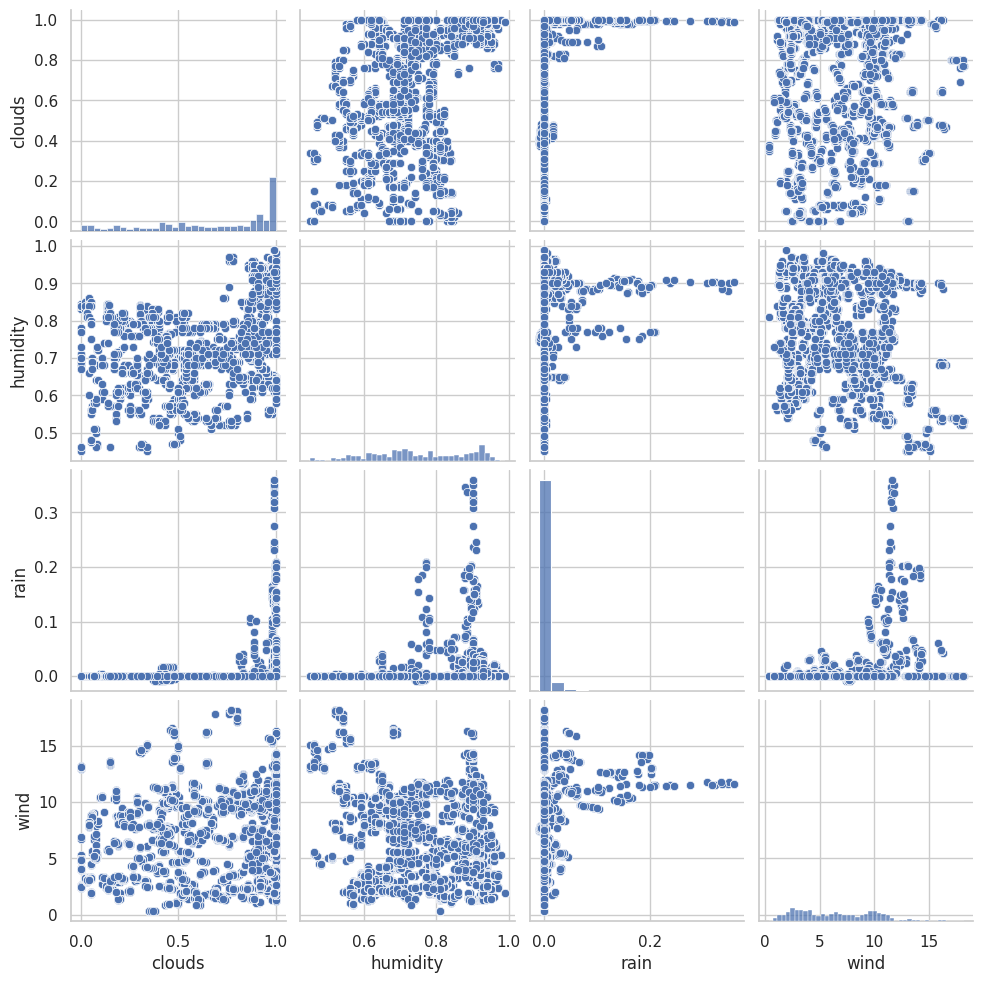

####Clusters Number

---
######**4 Clusters - Hierarchical**

In [425]:
'''
hierarchical = cluster.AgglomerativeClustering(n_clusters=4, linkage='average', affinity = 'euclidean')
hierarchical.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
C_h = hierarchical.labels_.astype(int)

sns.countplot(x=C_h)
C_h[:10]
'''

"\nhierarchical = cluster.AgglomerativeClustering(n_clusters=4, linkage='average', affinity = 'euclidean')\nhierarchical.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\nC_h = hierarchical.labels_.astype(int)\n\nsns.countplot(x=C_h)\nC_h[:10]\n"

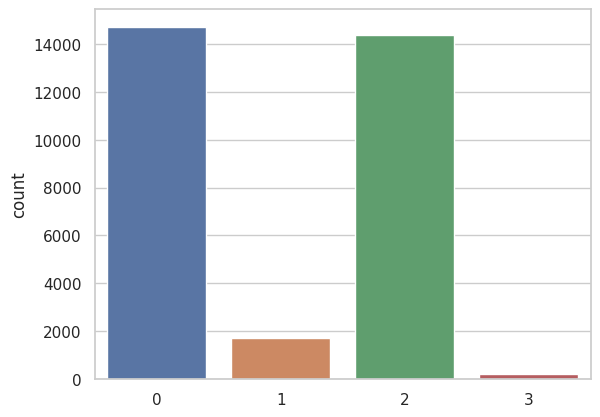

In [426]:
#C_h = hierarchical.fit_predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])

In [427]:
'''
df_combined['Hierarchical'] = C_h
df_combined['Hierarchical'] = df_combined['Hierarchical'].astype('category')

# Plot the clustering result
g = sns.pairplot(df_combined[['clouds', 'humidity', 'rain', 'wind', 'Hierarchical']],
                 hue='Hierarchical', diag_kind="hist", palette="tab10")
'''

'\ndf_combined[\'Hierarchical\'] = C_h\ndf_combined[\'Hierarchical\'] = df_combined[\'Hierarchical\'].astype(\'category\')\n\n# Plot the clustering result\ng = sns.pairplot(df_combined[[\'clouds\', \'humidity\', \'rain\', \'wind\', \'Hierarchical\']],\n                 hue=\'Hierarchical\', diag_kind="hist", palette="tab10")\n'

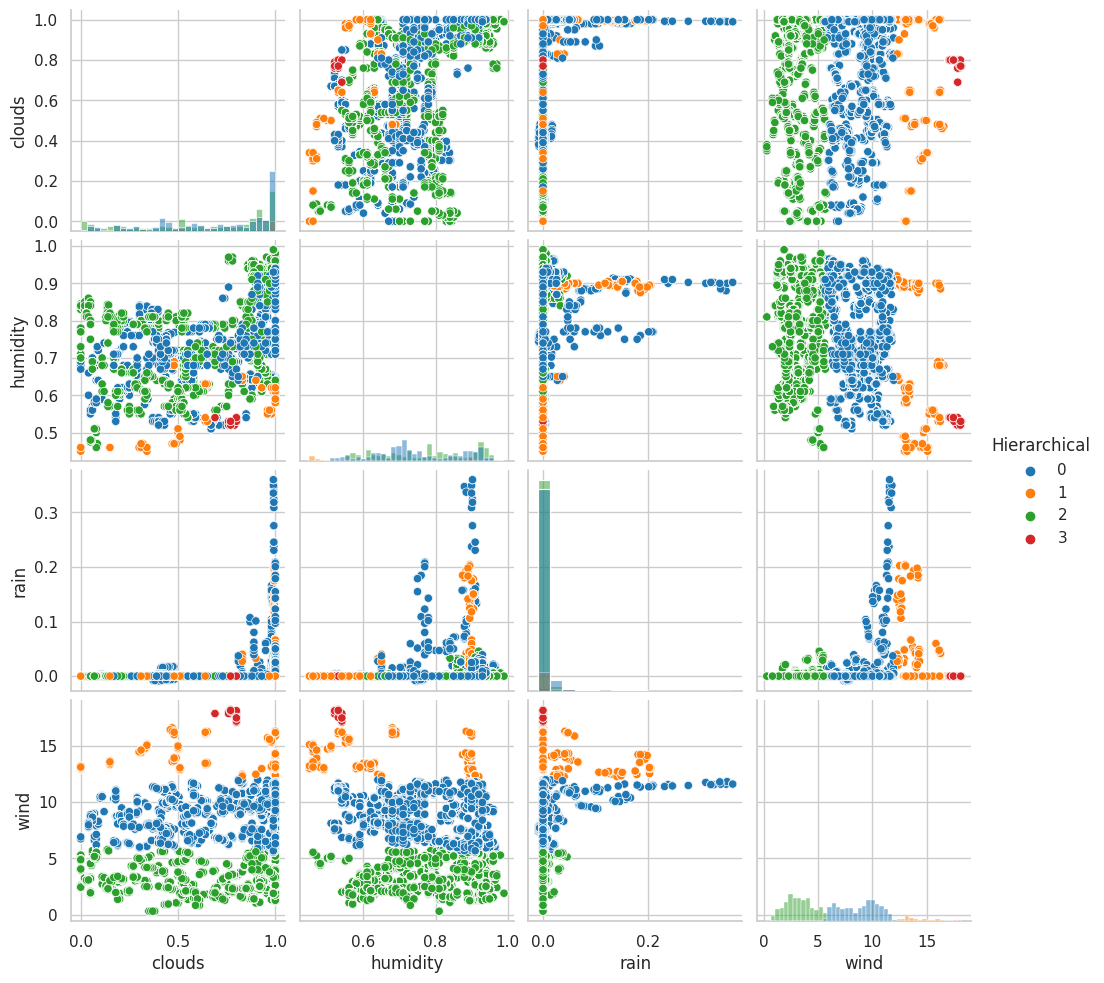

---
######**3 Clusters - Hierarchical**

In [428]:
'''
hierarchical = cluster.AgglomerativeClustering(n_clusters=3, linkage='average', affinity = 'euclidean')
hierarchical.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
C_h = hierarchical.labels_.astype(int)

sns.countplot(x=C_h)
C_h[:10]
'''

"\nhierarchical = cluster.AgglomerativeClustering(n_clusters=3, linkage='average', affinity = 'euclidean')\nhierarchical.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\nC_h = hierarchical.labels_.astype(int)\n\nsns.countplot(x=C_h)\nC_h[:10]\n"

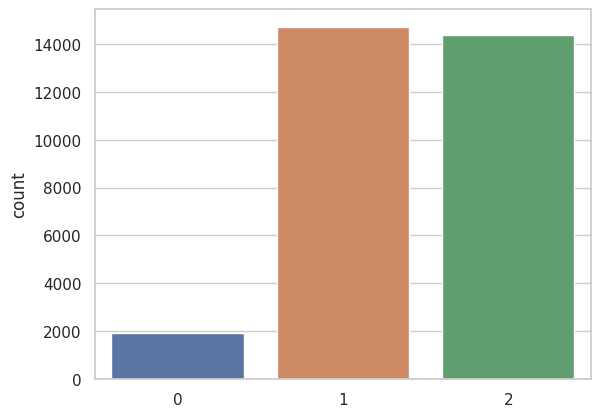

In [429]:
#C_h = hierarchical.fit_predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])

In [430]:
'''
df_combined['Hierarchical'] = C_h
df_combined['Hierarchical'] = df_combined['Hierarchical'].astype('category')

# Plot the clustering result
g = sns.pairplot(df_combined[['clouds', 'humidity', 'rain', 'wind', 'Hierarchical']],
                 hue='Hierarchical', diag_kind="hist", palette="tab10")
'''

'\ndf_combined[\'Hierarchical\'] = C_h\ndf_combined[\'Hierarchical\'] = df_combined[\'Hierarchical\'].astype(\'category\')\n\n# Plot the clustering result\ng = sns.pairplot(df_combined[[\'clouds\', \'humidity\', \'rain\', \'wind\', \'Hierarchical\']],\n                 hue=\'Hierarchical\', diag_kind="hist", palette="tab10")\n'

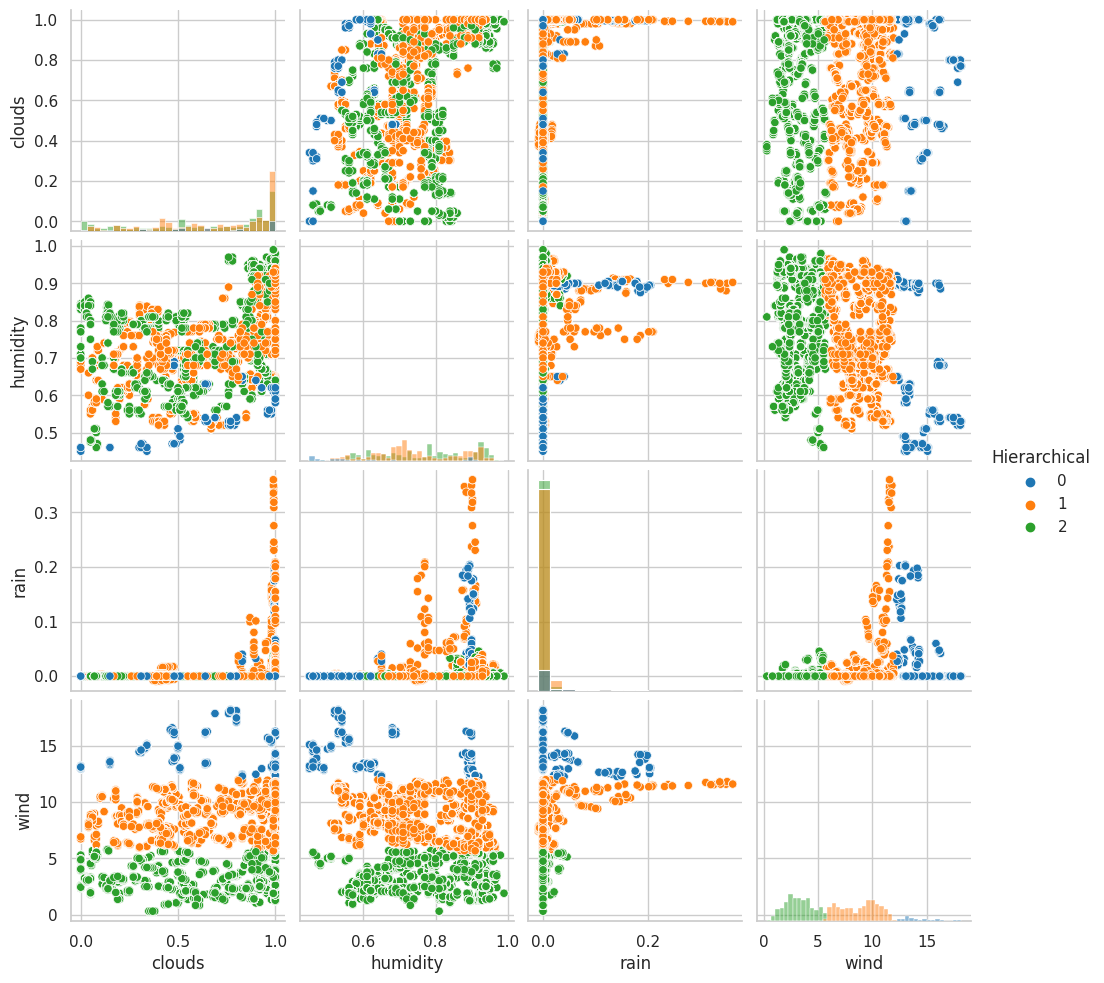

---
######**Finding Number of Clusters - Kmeans**

In [431]:
'''
distorsions, k1, kN = [], 2, 10
for k in range(k1, kN):
    kmeans = cluster.KMeans(n_clusters=k, init='k-means++').fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
    distorsions.append(kmeans.inertia_)

plt.plot(range(k1, kN), distorsions); plt.grid(True)
plt.title('Elbow curve')
'''

"\ndistorsions, k1, kN = [], 2, 10\nfor k in range(k1, kN):\n    kmeans = cluster.KMeans(n_clusters=k, init='k-means++').fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\n    distorsions.append(kmeans.inertia_)\n\nplt.plot(range(k1, kN), distorsions); plt.grid(True)\nplt.title('Elbow curve')\n"

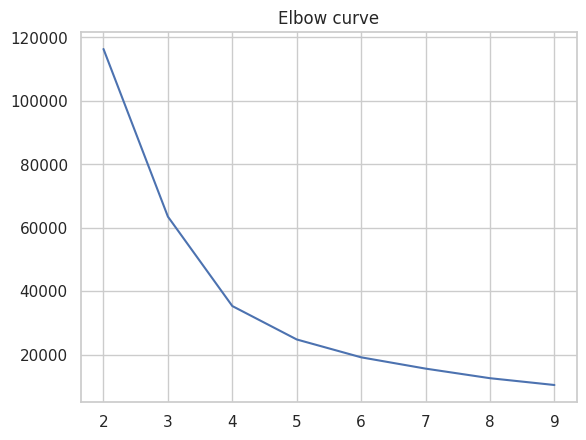

---
**4 Clusters Seems Good**

In [432]:
'''
km = cluster.KMeans(n_clusters=4, init='k-means++', random_state = 0)
km.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
# Hasil clusteringnya
C_km = km.predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])
p= sns.countplot(x=C_km)
'''

"\nkm = cluster.KMeans(n_clusters=4, init='k-means++', random_state = 0)\nkm.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\n# Hasil clusteringnya\nC_km = km.predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])\np= sns.countplot(x=C_km)\n"

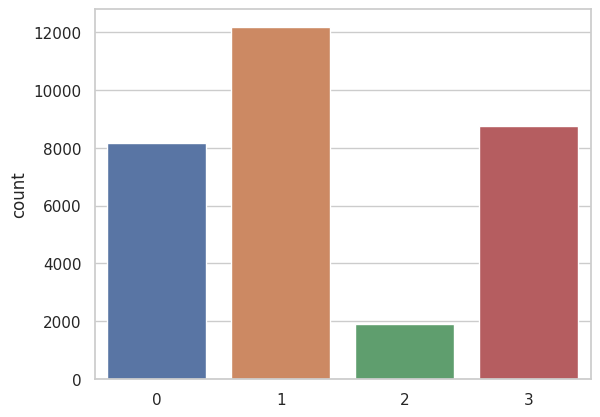

In [433]:
'''
df_combined['k-means++'] = C_km
g = sns.pairplot(df_combined[['clouds', 'humidity', 'rain', 'wind', 'k-means++']], \
                 hue="k-means++", diag_kind="hist", palette="tab10")
'''

'\ndf_combined[\'k-means++\'] = C_km\ng = sns.pairplot(df_combined[[\'clouds\', \'humidity\', \'rain\', \'wind\', \'k-means++\']],                  hue="k-means++", diag_kind="hist", palette="tab10")\n'

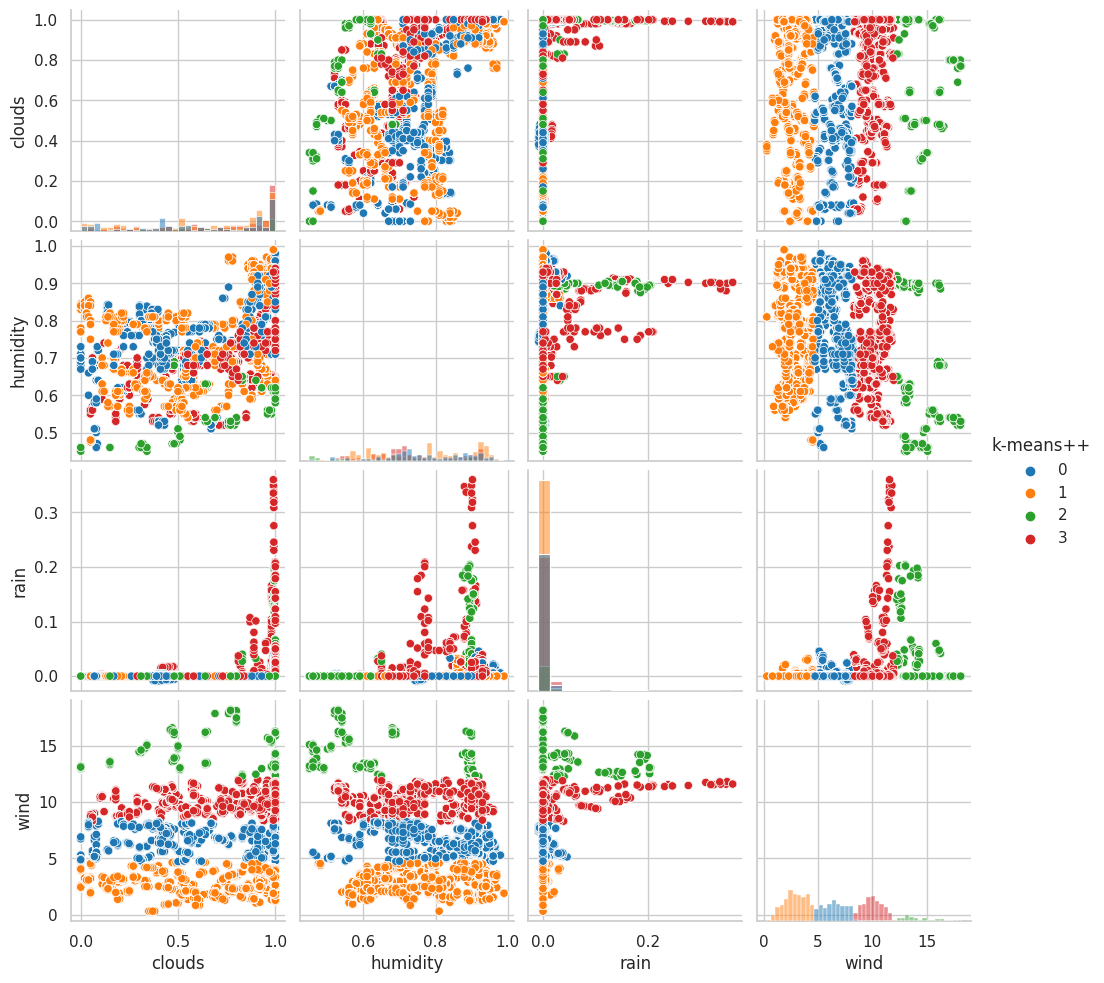

####Main Clustering

In [434]:
'''
km = cluster.KMeans(n_clusters=4, init='k-means++', random_state = 0)
km.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
# Hasil clusteringnya
C_km = km.predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])

df_combined['k-means++'] = C_km
'''

"\nkm = cluster.KMeans(n_clusters=4, init='k-means++', random_state = 0)\nkm.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\n# Hasil clusteringnya\nC_km = km.predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])\n\ndf_combined['k-means++'] = C_km\n"

###Restoration

In [435]:
'''
df_train_restored = df_combined.iloc[:train_end_index, :]
df_test_restored = df_combined.iloc[train_end_index:, :]
'''

'\ndf_train_restored = df_combined.iloc[:train_end_index, :]\ndf_test_restored = df_combined.iloc[train_end_index:, :]\n'

In [436]:
#df_train_restored.isna().sum()

In [437]:
#df_test_restored.drop(['price_mean'], axis=1, inplace=True)

In [438]:
#df_train_restored.shape, df_test_restored.shape

In [439]:
'''
df_test = df_test_restored
df_fill = df_train_restored
'''

'\ndf_test = df_test_restored\ndf_fill = df_train_restored\n'

In [440]:
'''
df_test['k-means++'] = df_test['k-means++'].astype('category')
df_fill['k-means++'] = df_fill['k-means++'].astype('category')
'''

"\ndf_test['k-means++'] = df_test['k-means++'].astype('category')\ndf_fill['k-means++'] = df_fill['k-means++'].astype('category')\n"

In [441]:
#df_test['k-means++'].unique()

In [442]:
#df_fill['k-means++'].unique()

## Mean Price and Mean Distance Clustering

###Setting Up

from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI

dbscan = cluster.DBSCAN(eps=0.625, min_samples=5, metric='euclidean')
X = df_[['price_mean','distance_mean']] #.values
dbscan.fit(X)
C_db = dbscan.labels_.astype(int)
sns.countplot(x=C_db)
C_db[:10]

In [443]:
'''
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI

X = df_fill[['price_mean','distance_mean']] #.values
'''

"\nfrom sklearn import cluster, datasets\nfrom sklearn.metrics import silhouette_score as siluet\nfrom sklearn.metrics.cluster import homogeneity_score as purity\nfrom sklearn.metrics import normalized_mutual_info_score as NMI\n\nX = df_fill[['price_mean','distance_mean']] #.values\n"

Hirarki



```
# Hierarchical http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
hierarchical = cluster.AgglomerativeClustering(n_clusters=4, linkage='average', affinity = 'euclidean')
hierarchical.fit(X) # Lambat .... dan menggunakan banyak memori O(N^2 log(N))
C_h = hierarchical.labels_.astype(int)

sns.countplot(x=C_h)
C_h[:10]
```



In [444]:
'''
# Hierarchical http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
hierarchical = cluster.AgglomerativeClustering(n_clusters=5, linkage='complete', affinity = 'euclidean')
hierarchical.fit(X) # Lambat .... dan menggunakan banyak memori O(N^2 log(N))
C_h = hierarchical.labels_.astype(int)

sns.countplot(x=C_h)
C_h[:10]
'''

"\n# Hierarchical http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering\nhierarchical = cluster.AgglomerativeClustering(n_clusters=5, linkage='complete', affinity = 'euclidean')\nhierarchical.fit(X) # Lambat .... dan menggunakan banyak memori O(N^2 log(N))\nC_h = hierarchical.labels_.astype(int)\n\nsns.countplot(x=C_h)\nC_h[:10]\n"



```
df_train['Hierarchical'] = C_h

# Plot the clustering result
g = sns.pairplot(df_train[['price_mean','distance_mean','Hierarchical']], \
                 hue="Hierarchical", diag_kind="hist", palette="tab10")
```



In [445]:
#df_fill['label_distance'] = C_h

In [446]:
'''
df_fill['label_distance'] = df_fill['label_distance'].apply(lambda x: 2 if x == 4 else x)

# Plot the clustering result
g = sns.pairplot(df_fill[['price_mean','distance_mean','label_distance']],
                 hue="label_distance", diag_kind="hist", palette="tab10")
'''

'\ndf_fill[\'label_distance\'] = df_fill[\'label_distance\'].apply(lambda x: 2 if x == 4 else x)\n\n# Plot the clustering result\ng = sns.pairplot(df_fill[[\'price_mean\',\'distance_mean\',\'label_distance\']],\n                 hue="label_distance", diag_kind="hist", palette="tab10")\n'

###Applying the Clustering

In [447]:
#import tensorflow as tf

In [448]:
'''
label_distmean = hierarchical.fit_predict(df_test)

df_test['label_distance'] = label_distmean
'''

"\nlabel_distmean = hierarchical.fit_predict(df_test)\n\ndf_test['label_distance'] = label_distmean\n"

In [449]:
#sns.countplot(x=df_test['label_distance'])

In [450]:
'''
# Plot
plt.figure(figsize=(60, 6))
sns.countplot(x='type', hue='label_distance', data=df_test)
plt.title('Count of combinations of label_distance and type')
plt.show()
'''

"\n# Plot\nplt.figure(figsize=(60, 6))\nsns.countplot(x='type', hue='label_distance', data=df_test)\nplt.title('Count of combinations of label_distance and type')\nplt.show()\n"

In [451]:
#df_test['label_distance'] = df_test['label_distance'].apply(lambda x: 2 if x == 4 else x)

#Preprocessing Part 2

## Adding Interaction Terms

In [452]:
df_fill.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'price_mean', 'rain', 'surge_max', 'surge_mean',
       'surge_min', 'temp', 'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin',
       'dm_cos', 'dw_sin', 'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat',
       'weather'],
      dtype='object')

In [453]:
df_test.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'rain', 'surge_max', 'surge_mean', 'surge_min', 'temp',
       'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin', 'dm_cos', 'dw_sin',
       'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat', 'wind_cat',
       'weather'],
      dtype='object')

In [454]:
df_train.shape, df_fill.shape, df_test.shape

((20006, 20), (20006, 24), (11040, 24))

In [455]:
df_fill['surge_mean_hour_sin'] = df_fill['surge_mean'] * df_fill['hour_sin']
df_fill['surge_mean_hour_cos'] = df_fill['surge_mean'] * df_fill['hour_cos']
df_fill['surge_mean_dw_cos'] = df_fill['surge_mean'] * df_fill['dw_cos']
df_fill['surge_mean_sw_sin'] = df_fill['surge_mean'] * df_fill['dw_sin']

In [456]:
df_fill['surge_max_hour_sin'] = df_fill['surge_max'] * df_fill['hour_sin']
df_fill['surge_max_hour_cos'] = df_fill['surge_max'] * df_fill['hour_cos']
df_fill['surge_max_dw_cos'] = df_fill['surge_max'] * df_fill['dw_cos']
df_fill['surge_max_sw_sin'] = df_fill['surge_max'] * df_fill['dw_sin']

In [457]:
df_fill['surge_min_hour_sin'] = df_fill['surge_min'] * df_fill['hour_sin']
df_fill['surge_min_hour_cos'] = df_fill['surge_min'] * df_fill['hour_cos']
df_fill['surge_min_dw_cos'] = df_fill['surge_min'] * df_fill['dw_cos']
df_fill['surge_min_sw_sin'] = df_fill['surge_min'] * df_fill['dw_sin']

In [458]:
df_fill['distance_mean_rain'] = df_fill['distance_mean'] * df_fill['rain']
df_fill['distance_max_rain'] = df_fill['distance_max'] * df_fill['rain']
df_fill['distance_min_rain'] = df_fill['distance_min'] * df_fill['rain']

In [459]:
df_fill['rain_hour_sin'] = df_fill['hour_sin'] * df_fill['rain']
df_fill['rain_hour_cos'] = df_fill['hour_cos'] * df_fill['rain']

In [460]:
df_fill['distance_mean_hour_cos'] = df_fill['hour_cos'] * df_fill['distance_mean']
df_fill['distance_max_hour_cos'] = df_fill['hour_cos'] * df_fill['distance_max']
df_fill['distance_min_hour_cos'] = df_fill['hour_cos'] * df_fill['distance_min']
df_fill['distance_mean_hour_sin'] = df_fill['hour_sin'] * df_fill['distance_mean']
df_fill['distance_max_hour_sin'] = df_fill['hour_sin'] * df_fill['distance_max']
df_fill['distance_min_hour_sin'] = df_fill['hour_sin'] * df_fill['distance_min']

In [461]:
df_fill['distance_mean_hour_cos_rain'] = df_fill['hour_cos'] * df_fill['distance_mean'] *df_fill['rain']
df_fill['distance_max_hour_cos_rain'] = df_fill['hour_cos'] * df_fill['distance_max'] *df_fill['rain']
df_fill['distance_min_hour_cos_rain'] = df_fill['hour_cos'] * df_fill['distance_min'] *df_fill['rain']
df_fill['distance_mean_hour_sin_rain'] = df_fill['hour_sin'] * df_fill['distance_mean'] *df_fill['rain']
df_fill['distance_max_hour_sin_rain'] = df_fill['hour_sin'] * df_fill['distance_max'] *df_fill['rain']
df_fill['distance_min_hour_sin_rain'] = df_fill['hour_sin'] * df_fill['distance_min'] *df_fill['rain']

In [462]:
df_fill.shape

(20006, 53)

In [463]:
df_test['surge_mean_hour_sin'] = df_test['surge_mean'] * df_test['hour_sin']
df_test['surge_mean_hour_cos'] = df_test['surge_mean'] * df_test['hour_cos']
df_test['surge_mean_dw_cos'] = df_test['surge_mean'] * df_test['dw_cos']
df_test['surge_mean_sw_sin'] = df_test['surge_mean'] * df_test['dw_sin']

In [464]:
df_test['surge_max_hour_sin'] = df_test['surge_max'] * df_test['hour_sin']
df_test['surge_max_hour_cos'] = df_test['surge_max'] * df_test['hour_cos']
df_test['surge_max_dw_cos'] = df_test['surge_max'] * df_test['dw_cos']
df_test['surge_max_sw_sin'] = df_test['surge_max'] * df_test['dw_sin']

In [465]:
df_test['surge_min_hour_sin'] = df_test['surge_min'] * df_test['hour_sin']
df_test['surge_min_hour_cos'] = df_test['surge_min'] * df_test['hour_cos']
df_test['surge_min_dw_cos'] = df_test['surge_min'] * df_test['dw_cos']
df_test['surge_min_sw_sin'] = df_test['surge_min'] * df_test['dw_sin']

In [466]:
df_test['distance_mean_rain'] = df_test['distance_mean'] * df_test['rain']
df_test['distance_max_rain'] = df_test['distance_max'] * df_test['rain']
df_test['distance_min_rain'] = df_test['distance_min'] * df_test['rain']

In [467]:
df_test['rain_hour_sin'] = df_test['hour_sin'] * df_test['rain']
df_test['rain_hour_cos'] = df_test['hour_cos'] * df_test['rain']

In [468]:
df_test['distance_mean_hour_cos'] = df_test['hour_cos'] * df_test['distance_mean']
df_test['distance_max_hour_cos'] = df_test['hour_cos'] * df_test['distance_max']
df_test['distance_min_hour_cos'] = df_test['hour_cos'] * df_test['distance_min']
df_test['distance_mean_hour_sin'] = df_test['hour_sin'] * df_test['distance_mean']
df_test['distance_max_hour_sin'] = df_test['hour_sin'] * df_test['distance_max']
df_test['distance_min_hour_sin'] = df_test['hour_sin'] * df_test['distance_min']

In [469]:
df_test['distance_mean_hour_cos_rain'] = df_test['hour_cos'] * df_test['distance_mean'] *df_test['rain']
df_test['distance_max_hour_cos_rain'] = df_test['hour_cos'] * df_test['distance_max'] *df_test['rain']
df_test['distance_min_hour_cos_rain'] = df_test['hour_cos'] * df_test['distance_min'] *df_test['rain']
df_test['distance_mean_hour_sin_rain'] = df_test['hour_sin'] * df_test['distance_mean'] *df_test['rain']
df_test['distance_max_hour_sin_rain'] = df_test['hour_sin'] * df_test['distance_max'] *df_test['rain']
df_test['distance_min_hour_sin_rain'] = df_test['hour_sin'] * df_test['distance_min'] *df_test['rain']

##Normalization **+ including y** **||CURRENTLY PLAN TO NOT BEING USED||**

In [470]:
df_test.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
wind_cat                       category
weather                        category
surge_mean_hour_sin             float64


In [471]:
df_fill.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
price_mean                      float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
surge_mean_hour_sin             float64


In [472]:
df_train['type'] = df_train['type'].astype('category')
df_test['type'] = df_test['type'].astype('category')
df_fill['type'] = df_fill['type'].astype('category')

'''
df_test['label_distance'] = df_test['label_distance'].astype('category')
df_fill['label_distance'] = df_fill['label_distance'].astype('category')
'''

"\ndf_test['label_distance'] = df_test['label_distance'].astype('category')\ndf_fill['label_distance'] = df_fill['label_distance'].astype('category')\n"

In [473]:
df_fill['type'] = df_fill['type'].astype('int64')
df_fill['type'] = df_fill['type'].astype('category')
df_fill['type'].unique()

[0, 85, 8, 20, 54, ..., 21, 63, 82, 37, 49]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [474]:
df_test['type'] = df_test['type'].astype('int64')
df_test['type'] = df_test['type'].astype('category')
df_test['type'].unique()

[0, 1, 2, 3, 4, ..., 91, 92, 93, 94, 95]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [475]:
df_train['type'] = df_train['type'].astype('int64')
df_train['type'] = df_train['type'].astype('category')
df_train['type'].unique()

[0, 85, 8, 20, 54, ..., 21, 63, 82, 37, 49]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [476]:
df_test.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
wind_cat                       category
weather                        category
surge_mean_hour_sin             float64


In [477]:
##Label X and y for regression
X1, y1 = df_train.drop(columns=['price_mean']), df_train.price_mean

In [478]:
# Separate the DataFrame based on data types

X1_combined = pd.concat([X1, df_test], axis=0, ignore_index=True)
X_num = X1_combined.select_dtypes(include=['int', 'float'])
X_cat = X1_combined.select_dtypes(include=['category'])

In [479]:
colname = X_num.columns

In [480]:
y1.shape

(20006,)

In [481]:
colname

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'rain', 'surge_max', 'surge_mean', 'surge_min', 'temp',
       'wind', 'hour_sin', 'hour_cos', 'dm_sin', 'dm_cos', 'dw_sin', 'dw_cos',
       'surge_mean_hour_sin', 'surge_mean_hour_cos', 'surge_mean_dw_cos',
       'surge_mean_sw_sin', 'surge_max_hour_sin', 'surge_max_hour_cos',
       'surge_max_dw_cos', 'surge_max_sw_sin', 'surge_min_hour_sin',
       'surge_min_hour_cos', 'surge_min_dw_cos', 'surge_min_sw_sin',
       'distance_mean_rain', 'distance_max_rain', 'distance_min_rain',
       'rain_hour_sin', 'rain_hour_cos', 'distance_mean_hour_cos',
       'distance_max_hour_cos', 'distance_min_hour_cos',
       'distance_mean_hour_sin', 'distance_max_hour_sin',
       'distance_min_hour_sin', 'distance_mean_hour_cos_rain',
       'distance_max_hour_cos_rain', 'distance_min_hour_cos_rain',
       'distance_mean_hour_sin_rain', 'distance_max_hour_sin_rain',
       'distance_min_hour_sin_ra

In [482]:
'''
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_num)
transformer
RobustScaler()
X_num=transformer.transform(X_num)

transformer2 = RobustScaler().fit(np.array(y1).reshape(-1, 1))
transformer2
RobustScaler()
y1=transformer2.transform(np.array(y1).reshape(-1, 1))
'''

'\nfrom sklearn.preprocessing import RobustScaler\ntransformer = RobustScaler().fit(X_num)\ntransformer\nRobustScaler()\nX_num=transformer.transform(X_num)\n\ntransformer2 = RobustScaler().fit(np.array(y1).reshape(-1, 1))\ntransformer2\nRobustScaler()\ny1=transformer2.transform(np.array(y1).reshape(-1, 1))\n'

In [483]:
#y1.reshape(20064, ).shape

In [484]:
X_num = pd.DataFrame(X_num)
X_num.columns = colname

In [485]:
X_cat

,type,humidity_cat,rain_cat,clouds_cat,wind_cat,weather
0,0,NaN,NaN,NaN,NaN,NaN
1,85,NaN,NaN,NaN,NaN,NaN
2,8,NaN,NaN,NaN,NaN,NaN
3,20,NaN,NaN,NaN,NaN,NaN
4,54,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
31041,95,low,No,low,high,clear
31042,95,low,No,low,high,clear
31043,95,low,No,low,high,clear
31044,95,low,No,low,high,clear


In [486]:
X_num.tail()

,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,surge_min,...,distance_min_hour_cos,distance_mean_hour_sin,distance_max_hour_sin,distance_min_hour_sin,distance_mean_hour_cos_rain,distance_max_hour_cos_rain,distance_min_hour_cos_rain,distance_mean_hour_sin_rain,distance_max_hour_sin_rain,distance_min_hour_sin_rain
31041,11.0,0.48,3.08,2.024545,0.72,0.47,0.0,1.0,1.0,1.0,...,-6.235383e-01,-1.012273,-1.540000,-0.360000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
31042,16.0,0.34,3.20,2.002500,0.72,0.46,0.0,1.0,1.0,1.0,...,-5.091169e-01,-1.415981,-2.262742,-0.509117,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
31043,7.0,0.31,3.08,2.105714,0.72,0.47,0.0,1.0,1.0,1.0,...,-3.600000e-01,-1.823602,-2.667358,-0.623538,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
31044,8.0,0.15,3.20,1.952500,0.72,0.46,0.0,1.0,1.0,1.0,...,-1.863497e-01,-1.885970,-3.090963,-0.695467,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
31045,9.0,0.00,3.15,2.721111,1.06,0.46,0.0,1.0,1.0,1.0,...,-1.947188e-16,-2.721111,-3.150000,-1.060000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [487]:
X1 = pd.concat([X_num, X_cat], axis=1)
X1

,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,surge_min,...,distance_min_hour_cos_rain,distance_mean_hour_sin_rain,distance_max_hour_sin_rain,distance_min_hour_sin_rain,type,humidity_cat,rain_cat,clouds_cat,wind_cat,weather
0,9.0,0.990667,3.03,1.726667,1.04,0.913333,0.0,1.50,1.055556,1.0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,11.0,0.990667,2.48,2.184545,1.35,0.913333,0.0,1.00,1.000000,1.0,...,NaN,NaN,NaN,NaN,85,NaN,NaN,NaN,NaN,NaN
2,6.0,0.990667,4.03,2.893333,1.27,0.920000,0.0,1.50,1.166667,1.0,...,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN
3,8.0,0.990667,3.24,2.193750,1.27,0.920000,0.0,1.25,1.062500,1.0,...,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN
4,7.0,0.990667,2.80,1.502857,1.13,0.913333,0.0,1.00,1.000000,1.0,...,NaN,NaN,NaN,NaN,54,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,11.0,0.480000,3.08,2.024545,0.72,0.470000,0.0,1.00,1.000000,1.0,...,-0.0,-0.0,-0.0,-0.0,95,low,No,low,high,clear
31042,16.0,0.340000,3.20,2.002500,0.72,0.460000,0.0,1.00,1.000000,1.0,...,-0.0,-0.0,-0.0,-0.0,95,low,No,low,high,clear
31043,7.0,0.310000,3.08,2.105714,0.72,0.470000,0.0,1.00,1.000000,1.0,...,-0.0,-0.0,-0.0,-0.0,95,low,No,low,high,clear
31044,8.0,0.150000,3.20,1.952500,0.72,0.460000,0.0,1.00,1.000000,1.0,...,-0.0,-0.0,-0.0,-0.0,95,low,No,low,high,clear


In [488]:
X1.isna().sum()

api_calls                          0
clouds                           192
distance_max                       0
distance_mean                      0
distance_min                       0
humidity                         192
rain                             192
surge_max                          0
surge_mean                         0
surge_min                          0
temp                             192
wind                             192
hour_sin                           0
hour_cos                           0
dm_sin                             0
dm_cos                             0
dw_sin                             0
dw_cos                             0
surge_mean_hour_sin            20006
surge_mean_hour_cos            20006
surge_mean_dw_cos              20006
surge_mean_sw_sin              20006
surge_max_hour_sin             20006
surge_max_hour_cos             20006
surge_max_dw_cos               20006
surge_max_sw_sin               20006
surge_min_hour_sin             20006
s

In [489]:
split_index = len(df_train)
df_test_1 = X1[split_index:]
X1 = X1.iloc[:split_index]

In [490]:
df_test_1.shape

(11040, 53)

In [491]:
X1.shape

(20006, 53)

In [492]:
##Label X and y for regression
X2, y2 = df_fill.drop(columns=['price_mean']), df_fill.price_mean

In [493]:
X2.isna().sum()

api_calls                      0
clouds                         0
distance_max                   0
distance_mean                  0
distance_min                   0
humidity                       0
rain                           0
surge_max                      0
surge_mean                     0
surge_min                      0
temp                           0
wind                           0
type                           0
hour_sin                       0
hour_cos                       0
dm_sin                         0
dm_cos                         0
dw_sin                         0
dw_cos                         0
humidity_cat                   0
rain_cat                       0
clouds_cat                     0
weather                        0
surge_mean_hour_sin            0
surge_mean_hour_cos            0
surge_mean_dw_cos              0
surge_mean_sw_sin              0
surge_max_hour_sin             0
surge_max_hour_cos             0
surge_max_dw_cos               0
surge_max_

In [494]:
X2.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
surge_mean_hour_sin             float64
surge_mean_hour_cos             float64


In [495]:
X2.shape

(20006, 52)

In [496]:
# Separate the DataFrame based on data types
X2_combined = pd.concat([X2, df_test], axis=0, ignore_index=True)
'''
X2_combined['label_distance'] = X2_combined['label_distance'].astype('int64')
X2_combined['label_distance'] = X2_combined['label_distance'].astype('category')
'''
X_num = X2_combined.select_dtypes(include=['int', 'float'])
X_cat = X2_combined.select_dtypes(include=['category'])

In [497]:
X2_combined.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
surge_mean_hour_sin             float64
surge_mean_hour_cos             float64


In [498]:
colname = X_num.columns

In [499]:
y2.shape

(20006,)

In [500]:
y2

0        16.555556
1        28.227273
2        23.250000
3        22.250000
4        12.785714
           ...    
20001     9.678571
20002    20.909091
20003    10.535714
20004    31.777778
20005    24.041667
Name: price_mean, Length: 20006, dtype: float64

In [501]:
'''
from sklearn.preprocessing import RobustScaler
transformer3 = RobustScaler().fit(X_num)
transformer3
RobustScaler()
X_num=transformer3.transform(X_num)

transformer4 = RobustScaler().fit(np.array(y2).reshape(-1, 1))
transformer4
RobustScaler()
y2=transformer4.transform(np.array(y2).reshape(-1, 1))
'''

'\nfrom sklearn.preprocessing import RobustScaler\ntransformer3 = RobustScaler().fit(X_num)\ntransformer3\nRobustScaler()\nX_num=transformer3.transform(X_num)\n\ntransformer4 = RobustScaler().fit(np.array(y2).reshape(-1, 1))\ntransformer4\nRobustScaler()\ny2=transformer4.transform(np.array(y2).reshape(-1, 1))\n'

In [502]:
#y2.reshape(20064, ).shape

In [503]:
X_num = pd.DataFrame(X_num)
X_num.columns = colname

In [504]:
X_num.tail()

,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,surge_min,...,distance_min_hour_cos,distance_mean_hour_sin,distance_max_hour_sin,distance_min_hour_sin,distance_mean_hour_cos_rain,distance_max_hour_cos_rain,distance_min_hour_cos_rain,distance_mean_hour_sin_rain,distance_max_hour_sin_rain,distance_min_hour_sin_rain
31041,11.0,0.48,3.08,2.024545,0.72,0.47,0.0,1.0,1.0,1.0,...,-6.235383e-01,-1.012273,-1.540000,-0.360000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
31042,16.0,0.34,3.20,2.002500,0.72,0.46,0.0,1.0,1.0,1.0,...,-5.091169e-01,-1.415981,-2.262742,-0.509117,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
31043,7.0,0.31,3.08,2.105714,0.72,0.47,0.0,1.0,1.0,1.0,...,-3.600000e-01,-1.823602,-2.667358,-0.623538,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
31044,8.0,0.15,3.20,1.952500,0.72,0.46,0.0,1.0,1.0,1.0,...,-1.863497e-01,-1.885970,-3.090963,-0.695467,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
31045,9.0,0.00,3.15,2.721111,1.06,0.46,0.0,1.0,1.0,1.0,...,-1.947188e-16,-2.721111,-3.150000,-1.060000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [505]:
X_cat = X_cat.reset_index(drop=True)
X_cat.tail()

,type,humidity_cat,rain_cat,clouds_cat,weather,wind_cat
31041,95,low,No,low,clear,high
31042,95,low,No,low,clear,high
31043,95,low,No,low,clear,high
31044,95,low,No,low,clear,high
31045,95,low,No,low,clear,high


In [506]:
X2 = pd.concat([X_num, X_cat], axis=1)
X2

,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,surge_min,...,distance_min_hour_cos_rain,distance_mean_hour_sin_rain,distance_max_hour_sin_rain,distance_min_hour_sin_rain,type,humidity_cat,rain_cat,clouds_cat,weather,wind_cat
0,9.0,0.990667,3.03,1.726667,1.04,0.913333,0.0,1.50,1.055556,1.0,...,0.0,0.0,0.0,0.0,0,high,No,high,cloudy,NaN
1,11.0,0.990667,2.48,2.184545,1.35,0.913333,0.0,1.00,1.000000,1.0,...,0.0,0.0,0.0,0.0,85,high,No,high,cloudy,NaN
2,6.0,0.990667,4.03,2.893333,1.27,0.920000,0.0,1.50,1.166667,1.0,...,0.0,0.0,0.0,0.0,8,high,No,high,cloudy,NaN
3,8.0,0.990667,3.24,2.193750,1.27,0.920000,0.0,1.25,1.062500,1.0,...,0.0,0.0,0.0,0.0,20,high,No,high,cloudy,NaN
4,7.0,0.990667,2.80,1.502857,1.13,0.913333,0.0,1.00,1.000000,1.0,...,0.0,0.0,0.0,0.0,54,high,No,high,cloudy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,11.0,0.480000,3.08,2.024545,0.72,0.470000,0.0,1.00,1.000000,1.0,...,-0.0,-0.0,-0.0,-0.0,95,low,No,low,clear,high
31042,16.0,0.340000,3.20,2.002500,0.72,0.460000,0.0,1.00,1.000000,1.0,...,-0.0,-0.0,-0.0,-0.0,95,low,No,low,clear,high
31043,7.0,0.310000,3.08,2.105714,0.72,0.470000,0.0,1.00,1.000000,1.0,...,-0.0,-0.0,-0.0,-0.0,95,low,No,low,clear,high
31044,8.0,0.150000,3.20,1.952500,0.72,0.460000,0.0,1.00,1.000000,1.0,...,-0.0,-0.0,-0.0,-0.0,95,low,No,low,clear,high


In [507]:
split_index = len(df_train)
df_test_2 = X2[split_index:]
X2 = X2.iloc[:split_index]

In [508]:
df_test_2.shape

(11040, 53)

In [509]:
X2.shape

(20006, 53)

In [510]:
X2.isna().sum()

api_calls                          0
clouds                             0
distance_max                       0
distance_mean                      0
distance_min                       0
humidity                           0
rain                               0
surge_max                          0
surge_mean                         0
surge_min                          0
temp                               0
wind                               0
hour_sin                           0
hour_cos                           0
dm_sin                             0
dm_cos                             0
dw_sin                             0
dw_cos                             0
surge_mean_hour_sin                0
surge_mean_hour_cos                0
surge_mean_dw_cos                  0
surge_mean_sw_sin                  0
surge_max_hour_sin                 0
surge_max_hour_cos                 0
surge_max_dw_cos                   0
surge_max_sw_sin                   0
surge_min_hour_sin                 0
s

___
**X1 and y1 is from df_train which still have missing values. While X2 and y2 is from df_fill, which has been filled(imputed). Adjust it to your corresponding model.**

**df_test1 and df_test2 are their counterpart.**

---
#**You're Now Entering the Modelling Zone**
---


#LGBM

##Embedding

###Tensorflow Keras Embedding (Don't run if Embedding is a no no)

####Specific Preparation

In [511]:
import tensorflow as tf

In [512]:
X2['type'].unique()

[0, 85, 8, 20, 54, ..., 21, 63, 82, 37, 49]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [513]:
X2.head()

,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,rain,surge_max,surge_mean,surge_min,...,distance_min_hour_cos_rain,distance_mean_hour_sin_rain,distance_max_hour_sin_rain,distance_min_hour_sin_rain,type,humidity_cat,rain_cat,clouds_cat,weather,wind_cat
0,9.0,0.990667,3.03,1.726667,1.04,0.913333,0.0,1.50,1.055556,1.0,...,0.0,0.0,0.0,0.0,0,high,No,high,cloudy,NaN
1,11.0,0.990667,2.48,2.184545,1.35,0.913333,0.0,1.00,1.000000,1.0,...,0.0,0.0,0.0,0.0,85,high,No,high,cloudy,NaN
2,6.0,0.990667,4.03,2.893333,1.27,0.920000,0.0,1.50,1.166667,1.0,...,0.0,0.0,0.0,0.0,8,high,No,high,cloudy,NaN
3,8.0,0.990667,3.24,2.193750,1.27,0.920000,0.0,1.25,1.062500,1.0,...,0.0,0.0,0.0,0.0,20,high,No,high,cloudy,NaN
4,7.0,0.990667,2.80,1.502857,1.13,0.913333,0.0,1.00,1.000000,1.0,...,0.0,0.0,0.0,0.0,54,high,No,high,cloudy,NaN


In [514]:
X2 = X2[X2.columns[-7:].tolist() + X2.columns[:-7].tolist()]
X2.dtypes

distance_min_hour_sin_rain      float64
type                           category
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
wind_cat                       category
api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64


In [515]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

#X2 = df_column_switch(X2, 'k-means++', 'day_of_week_cat')

In [516]:
#X2['k-means++'].unique()

In [517]:
X2.dtypes

distance_min_hour_sin_rain      float64
type                           category
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
wind_cat                       category
api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64


In [518]:
df_test_2 = df_test_2[df_test_2.columns[-7:].tolist() + df_test_2.columns[:-7].tolist()]
df_test_2.dtypes

distance_min_hour_sin_rain      float64
type                           category
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
wind_cat                       category
api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64


In [519]:
#df_test_2 = df_column_switch(df_test_2, 'k-means++', 'day_of_week_cat')

In [520]:
df_test_2.dtypes

distance_min_hour_sin_rain      float64
type                           category
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
wind_cat                       category
api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64


In [521]:
from sklearn.model_selection import train_test_split
#X2_dum = X2.copy()
X2_dum = pd.get_dummies(X2, drop_first=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_dum, y2, test_size=0.25, random_state=69)

In [522]:
X2_dum.isna().sum()

distance_min_hour_sin_rain    0
api_calls                     0
clouds                        0
distance_max                  0
distance_mean                 0
                             ..
clouds_cat_high               0
weather_cloudy                0
weather_rainy                 0
wind_cat_medium               0
wind_cat_high                 0
Length: 151, dtype: int64

In [523]:
X2_train.shape, X2_test.shape

((15004, 151), (5002, 151))

In [524]:
tf.random.set_seed(66)

In [525]:
from sklearn.model_selection import KFold

In [526]:
X2_dum1 = np.array(X2_dum)
y21 = np.array(y2)

In [527]:
#X2['k-means++'].unique()

In [528]:
X2['humidity'].describe()

count    20006.000000
mean         0.749084
std          0.137490
min          0.460000
25%          0.630000
50%          0.730000
75%          0.890000
max          0.990000
Name: humidity, dtype: float64

In [529]:
X2['type'] = X2['type'].astype('int64')
df_test_2['type'] = df_test_2['type'].astype('int64')

'''
mapping_dict = {"low": 0, "medium": 1, "high": 2}

X2['humidity_cat'] = X2['humidity_cat'].map(mapping_dict)
X2['clouds_cat'] = X2['clouds_cat'].map(mapping_dict)
df_test_2['humidity_cat'] = df_test_2['humidity_cat'].map(mapping_dict)
df_test_2['clouds_cat'] = df_test_2['clouds_cat'].map(mapping_dict)

X2['humidity_cat'] = X2['humidity_cat'].astype('int64')
df_test_2['humidity_cat'] = df_test_2['humidity_cat'].astype('int64')
X2['clouds_cat'] = X2['clouds_cat'].astype('int64')
df_test_2['clouds_cat'] = df_test_2['clouds_cat'].astype('int64')


X2['day_of_week_cat'] = X2['day_of_week_cat'].astype('int64')
df_test_2['day_of_week_cat'] = df_test_2['day_of_week_cat'].astype('int64')
X2['hour_cat'] = X2['hour_cat'].astype('int64')
df_test_2['hour_cat'] = df_test_2['hour_cat'].astype('int64')


X2['k-means++'] = X2['k-means++'].astype('int64')
df_test_2['k-means++'] = df_test_2['k-means++'].astype('int64')
X2['day_of_week_cat'] = X2['day_of_week_cat'].astype('int64')
X2['hour_cat'] = X2['hour_cat'].astype('int64')
'''

'\nmapping_dict = {"low": 0, "medium": 1, "high": 2}\n\nX2[\'humidity_cat\'] = X2[\'humidity_cat\'].map(mapping_dict)\nX2[\'clouds_cat\'] = X2[\'clouds_cat\'].map(mapping_dict)\ndf_test_2[\'humidity_cat\'] = df_test_2[\'humidity_cat\'].map(mapping_dict)\ndf_test_2[\'clouds_cat\'] = df_test_2[\'clouds_cat\'].map(mapping_dict)\n\nX2[\'humidity_cat\'] = X2[\'humidity_cat\'].astype(\'int64\')\ndf_test_2[\'humidity_cat\'] = df_test_2[\'humidity_cat\'].astype(\'int64\')\nX2[\'clouds_cat\'] = X2[\'clouds_cat\'].astype(\'int64\')\ndf_test_2[\'clouds_cat\'] = df_test_2[\'clouds_cat\'].astype(\'int64\')\n\n\nX2[\'day_of_week_cat\'] = X2[\'day_of_week_cat\'].astype(\'int64\')\ndf_test_2[\'day_of_week_cat\'] = df_test_2[\'day_of_week_cat\'].astype(\'int64\')\nX2[\'hour_cat\'] = X2[\'hour_cat\'].astype(\'int64\')\ndf_test_2[\'hour_cat\'] = df_test_2[\'hour_cat\'].astype(\'int64\')\n\n\nX2[\'k-means++\'] = X2[\'k-means++\'].astype(\'int64\')\ndf_test_2[\'k-means++\'] = df_test_2[\'k-means++\'].astyp

In [530]:
X2.isna().sum()

distance_min_hour_sin_rain         0
type                               0
humidity_cat                       0
rain_cat                           0
clouds_cat                         0
weather                            0
wind_cat                       20006
api_calls                          0
clouds                             0
distance_max                       0
distance_mean                      0
distance_min                       0
humidity                           0
rain                               0
surge_max                          0
surge_mean                         0
surge_min                          0
temp                               0
wind                               0
hour_sin                           0
hour_cos                           0
dm_sin                             0
dm_cos                             0
dw_sin                             0
dw_cos                             0
surge_mean_hour_sin                0
surge_mean_hour_cos                0
s

In [531]:
X2 = pd.get_dummies(X2, drop_first=True)
X2.dtypes

distance_min_hour_sin_rain     float64
type                             int64
api_calls                      float64
clouds                         float64
distance_max                   float64
distance_mean                  float64
distance_min                   float64
humidity                       float64
rain                           float64
surge_max                      float64
surge_mean                     float64
surge_min                      float64
temp                           float64
wind                           float64
hour_sin                       float64
hour_cos                       float64
dm_sin                         float64
dm_cos                         float64
dw_sin                         float64
dw_cos                         float64
surge_mean_hour_sin            float64
surge_mean_hour_cos            float64
surge_mean_dw_cos              float64
surge_mean_sw_sin              float64
surge_max_hour_sin             float64
surge_max_hour_cos       

In [532]:
df_test_2 = pd.get_dummies(df_test_2, drop_first=True)
df_test_2.dtypes

distance_min_hour_sin_rain     float64
type                             int64
api_calls                      float64
clouds                         float64
distance_max                   float64
distance_mean                  float64
distance_min                   float64
humidity                       float64
rain                           float64
surge_max                      float64
surge_mean                     float64
surge_min                      float64
temp                           float64
wind                           float64
hour_sin                       float64
hour_cos                       float64
dm_sin                         float64
dm_cos                         float64
dw_sin                         float64
dw_cos                         float64
surge_mean_hour_sin            float64
surge_mean_hour_cos            float64
surge_mean_dw_cos              float64
surge_mean_sw_sin              float64
surge_max_hour_sin             float64
surge_max_hour_cos       

In [533]:
X2 = np.array(X2)

####Setting Up for Training

In [534]:
X2.shape

(20006, 57)

In [535]:
time_steps = 96
features = 52

X2_dum = np.array(X2)

In [536]:
time_steps2 = 96
features2 = 1

In [537]:
X2_dum.shape

(20006, 57)

In [538]:
# Reshape y21 to have the same number of dimensions as X2_dum1
y21_reshaped = y21.reshape((y21.shape[0], 1))

# Combine X2_dum1 and y21 along the last axis
combined_array = np.concatenate((X2_dum, y21_reshaped), axis=1)

In [539]:
combined_array.shape

(20006, 58)

In [540]:
# Extract features (X) and target variable (y) from the combined array
X = combined_array[:, :-1]  # All columns except the last one
y = combined_array[:, -1]   # Last column

# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5/19, shuffle=False)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.4, shuffle=False)

# Print the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (14741, 57)
X_test shape: (3159, 57)
y_train shape: (14741,)
y_test shape: (3159,)
X_valid shape: (2106, 57)
y_valid shape: (2106,)


In [541]:
X.shape

(20006, 57)

In [542]:
df_test_2 = np.array(df_test_2)

In [543]:
print("X:", X.shape)
print("y:", y.shape)

X: (20006, 57)
y: (20006,)


####Embedding with Tensorflow Keras

In [544]:
features = X2.shape[1]
features

57

In [545]:
embedding = 95

In [546]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 69

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [547]:
# INPUT - FIRST 3 COLUMNS ARE CAT, REST ARE NUMERIC
inp = tf.keras.Input(shape=(features))
embeddings = []
emb = tf.keras.layers.Embedding(96,embedding)
embeddings.append(emb(inp[:,0]))

x = tf.keras.layers.Concatenate(axis=-1)([inp[:,1:]]+embeddings)

# COMPILE MODEL
model = tf.keras.Model(inputs=inp, outputs=x)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.mse
model.compile(loss=loss, optimizer = opt)

In [548]:
# Assuming you have X_train, y_train, X_val, y_val for training and validation data

hist = model.fit(X, y, epochs=5, verbose=1)

Epoch 1/5
626/626 [==============================] - 3s 4ms/step - loss: 448.5532
Epoch 2/5
626/626 [==============================] - 3s 4ms/step - loss: 434.0578
Epoch 3/5
626/626 [==============================] - 2s 4ms/step - loss: 420.2054
Epoch 4/5
626/626 [==============================] - 2s 3ms/step - loss: 406.9446
Epoch 5/5
626/626 [==============================] - 2s 3ms/step - loss: 394.2459


In [549]:
X = model.predict(X).reshape(20006, (features+embedding-1))

626/626 [==============================] - 2s 3ms/step


In [550]:
df_test_2 = model.predict(df_test_2).reshape(11040, features+embedding-1)

345/345 [==============================] - 1s 3ms/step


In [551]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,0.0,9.0,0.990667,3.03,1.726667,1.04,0.913333,0.0,1.50,1.055556,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
1,85.0,11.0,0.990667,2.48,2.184546,1.35,0.913333,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
2,8.0,6.0,0.990667,4.03,2.893333,1.27,0.920000,0.0,1.50,1.166667,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
3,20.0,8.0,0.990667,3.24,2.193750,1.27,0.920000,0.0,1.25,1.062500,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
4,54.0,7.0,0.990667,2.80,1.502857,1.13,0.913333,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20001,47.0,14.0,0.540000,3.00,2.171429,0.83,0.660000,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
20002,3.0,11.0,0.540000,4.46,3.130909,1.44,0.670000,0.0,1.25,1.022727,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
20003,40.0,14.0,0.540000,5.15,2.805000,0.45,0.620000,0.0,1.75,1.053571,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
20004,92.0,9.0,0.540000,4.57,3.015556,1.64,0.670000,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053


In [552]:
y = y.reshape(20006,)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

# Print the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15004, 151)
X_test shape: (5002, 151)
y_train shape: (15004,)
y_test shape: (5002,)


In [553]:
pd.DataFrame(df_test_2)

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,0.0,13.0,0.69,3.02,1.980000,1.06,0.68,0.0,2.00,1.115385,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
1,0.0,14.0,0.77,2.34,1.541429,1.04,0.68,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
2,0.0,13.0,0.59,3.00,2.010769,1.08,0.69,0.0,1.50,1.096154,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
3,0.0,12.0,0.68,3.14,1.860833,1.06,0.70,0.0,1.25,1.020833,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
4,0.0,7.0,0.72,2.41,1.634286,1.06,0.71,0.0,1.25,1.035714,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11035,95.0,11.0,0.48,3.08,2.024545,0.72,0.47,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
11036,95.0,16.0,0.34,3.20,2.002500,0.72,0.46,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
11037,95.0,7.0,0.31,3.08,2.105714,0.72,0.47,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
11038,95.0,8.0,0.15,3.20,1.952500,0.72,0.46,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053


---
---
---

##Model Fitting and Predicting

In [273]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error

###More Outliers Handling **(Optional)** (Only Run 1 SubHeader, not Both)

**Do Note that DBSCAN ALWAYS return the same cluster result, so one dbscan is all it takes.**

**However, the splitting in X and y to train and test is random, so a necessity to do dbscan inside the loop is relevant in cross-validation.**

####For 1 Try

#####The Outliers Splitting

In [ ]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.shape, y.shape

((20006, 151), (20006, 1))

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,0.0,9.0,0.990667,3.03,1.726667,1.04,0.913333,0.0,1.50,1.055556,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
1,85.0,11.0,0.990667,2.48,2.184546,1.35,0.913333,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
2,8.0,6.0,0.990667,4.03,2.893333,1.27,0.920000,0.0,1.50,1.166667,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
3,20.0,8.0,0.990667,3.24,2.193750,1.27,0.920000,0.0,1.25,1.062500,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
4,54.0,7.0,0.990667,2.80,1.502857,1.13,0.913333,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053


In [ ]:
from sklearn.cluster import DBSCAN

y = y.rename(columns={0: 'resp'})

df_combined = pd.concat([X, y], axis=1)

In [ ]:
df_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,resp
0,0.0,9.0,0.990667,3.03,1.726667,1.04,0.913333,0.0,1.50,1.055556,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,16.555556
1,85.0,11.0,0.990667,2.48,2.184546,1.35,0.913333,0.0,1.00,1.000000,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,28.227273
2,8.0,6.0,0.990667,4.03,2.893333,1.27,0.920000,0.0,1.50,1.166667,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,23.250000
3,20.0,8.0,0.990667,3.24,2.193750,1.27,0.920000,0.0,1.25,1.062500,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,22.250000
4,54.0,7.0,0.990667,2.80,1.502857,1.13,0.913333,0.0,1.00,1.000000,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,12.785714


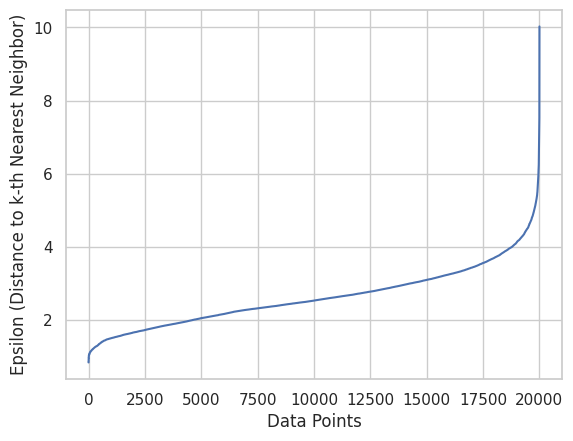

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming X is your feature matrix
neighbors = NearestNeighbors(n_neighbors=2)
distances, indices = neighbors.fit(X).kneighbors(X)

distances = distances[:, 1]
distances = np.sort(distances, axis=0)

plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Epsilon (Distance to k-th Nearest Neighbor)')
plt.show()

In [ ]:
dbscan = DBSCAN(eps=3, min_samples=5)
df_combined.columns = df_combined.columns.astype(str)
df_combined['cluster_label'] = dbscan.fit_predict(df_combined)

In [ ]:
# Extract outliers (points with cluster_label == -1)
outliers_combined = df_combined[df_combined['cluster_label'] == -1]

In [ ]:
#The Outliers
outliers_combined.drop(['cluster_label'], axis=1, inplace=True)
X_outliers = outliers_combined.iloc[:, :-2]
y_outliers = outliers_combined.iloc[:, -1]

In [ ]:
# Without Outliers
df_no_outliers_combined = df_combined[df_combined['cluster_label'] != -1]
df_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)

In [ ]:
X_no_outliers = df_no_outliers_combined.iloc[:, :-1]
y_no_outliers = df_no_outliers_combined.iloc[:, -1]

In [ ]:
X_no_outliers.shape, y_no_outliers.shape, X.shape, y.shape

((2232, 151), (2232,), (20006, 151), (20006, 1))

In [ ]:
X_no_outliers.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
36,67.0,5.0,0.990667,3.35,2.724000,0.74,0.918,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
99,66.0,4.0,0.957500,3.44,2.312500,1.11,0.925,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
136,31.0,12.0,0.957500,3.30,2.146667,0.76,0.925,0.0,1.25,1.020833,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
185,68.0,6.0,0.965000,3.24,2.381667,1.40,0.930,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
186,29.0,8.0,0.967500,2.37,1.182500,0.54,0.920,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053


In [ ]:
y_no_outliers.head()

36      6.700000
99      6.125000
136    30.625000
185     6.333333
186    27.062500
Name: resp, dtype: float64

#####The Cross Validation (Same Outliers)

In [ ]:
folds = 10

best_hyperparameters= {
 'l2_leaf_reg': 0.7456962724418824,
 'max_bin': 419,
 'learning_rate': 0.09167898059457538,
 'max_depth': 7,
 'random_state': 95,
 'min_data_in_leaf': 59,
 'rsm' : 0.6
              }

catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X, y, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

Fold 1: RMSE = 0.592355981817887
Fold 2: RMSE = 0.6316915716573661
Fold 3: RMSE = 0.5332129345274076
Fold 4: RMSE = 0.5600632678528892
Fold 5: RMSE = 0.5884843025028662
Fold 6: RMSE = 0.5854923661791023
Fold 7: RMSE = 0.5789412722174937
Fold 8: RMSE = 0.5708421505302688
Fold 9: RMSE = 0.5751277482068141
Fold 10: RMSE = 0.5520180156001204

Mean RMSE across folds: 0.5768229611092215


####For Cross Validation (Different Outliers as Different Train-Test-Split)



In [ ]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.shape, y.shape

((20006, 151), (20006, 1))

In [ ]:
from sklearn.cluster import DBSCAN
import pandas as pd

y = y.rename(columns={0: 'resp'})

In [ ]:
folds = 10
best_hyperparameters= {
 'l2_leaf_reg': 0.7456962724418824,
 'max_bin': 419,
 'learning_rate': 0.09167898059457538,
 'max_depth': 7,
 'random_state': 95,
 'min_data_in_leaf': 59,
 'rsm' : 0.6
 }
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

rmse_scores = []

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply DBSCAN on the training set
    df_train_combined = pd.concat([X_train, y_train], axis=1)
    dbscan = DBSCAN(eps=7, min_samples=5)
    df_train_combined.columns = df_train_combined.columns.astype(str)
    df_train_combined['cluster_label'] = dbscan.fit_predict(df_train_combined)

    # Without Outliers in the training set
    df_train_no_outliers_combined = df_train_combined[df_train_combined['cluster_label'] != -1]
    df_train_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)
    X_train_no_outliers = df_train_no_outliers_combined.iloc[:, :-1]
    y_train_no_outliers = df_train_no_outliers_combined.iloc[:, -1]

    # Fit the CatBoost model on the training set without outliers
    catboost_model.fit(X_train_no_outliers, y_train_no_outliers, verbose=0)

    # Evaluate the model on the validation set
    y_pred = catboost_model.predict(X_test)
    rmse_score = rmse(y_test, y_pred)

    rmse_scores.append(rmse_score)

    print(f"RMSE on Validation Set: {rmse_score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

RMSE on Validation Set: 0.5840680205296415
RMSE on Validation Set: 0.6953076671904974
RMSE on Validation Set: 0.5273689867195347
RMSE on Validation Set: 0.5664618148760957
RMSE on Validation Set: 0.6095358773355241
RMSE on Validation Set: 0.6098841964726563
RMSE on Validation Set: 0.5826889508623062
RMSE on Validation Set: 0.5696405580927215
RMSE on Validation Set: 0.5725118286489811
RMSE on Validation Set: 0.5666926914481263

Mean RMSE across folds: 0.5884160592176084


###Feature Selection **(Optional)**

####For 1 Try

#####Fitting For Feature Selection

In [ ]:
best_hyperparameters= {
 'l2_leaf_reg': 0.7456962724418824,
 'max_bin': 419,
 'learning_rate': 0.09167898059457538,
 'max_depth': 7,
 'random_state': 95,
 'min_data_in_leaf': 59,
 'rsm' : 0.6
 }

catboost_model = CatBoostRegressor(**best_hyperparameters)
catboost_model.fit(X, y, verbose=0)

#####The Filtering

In [ ]:
X = pd.DataFrame(X)

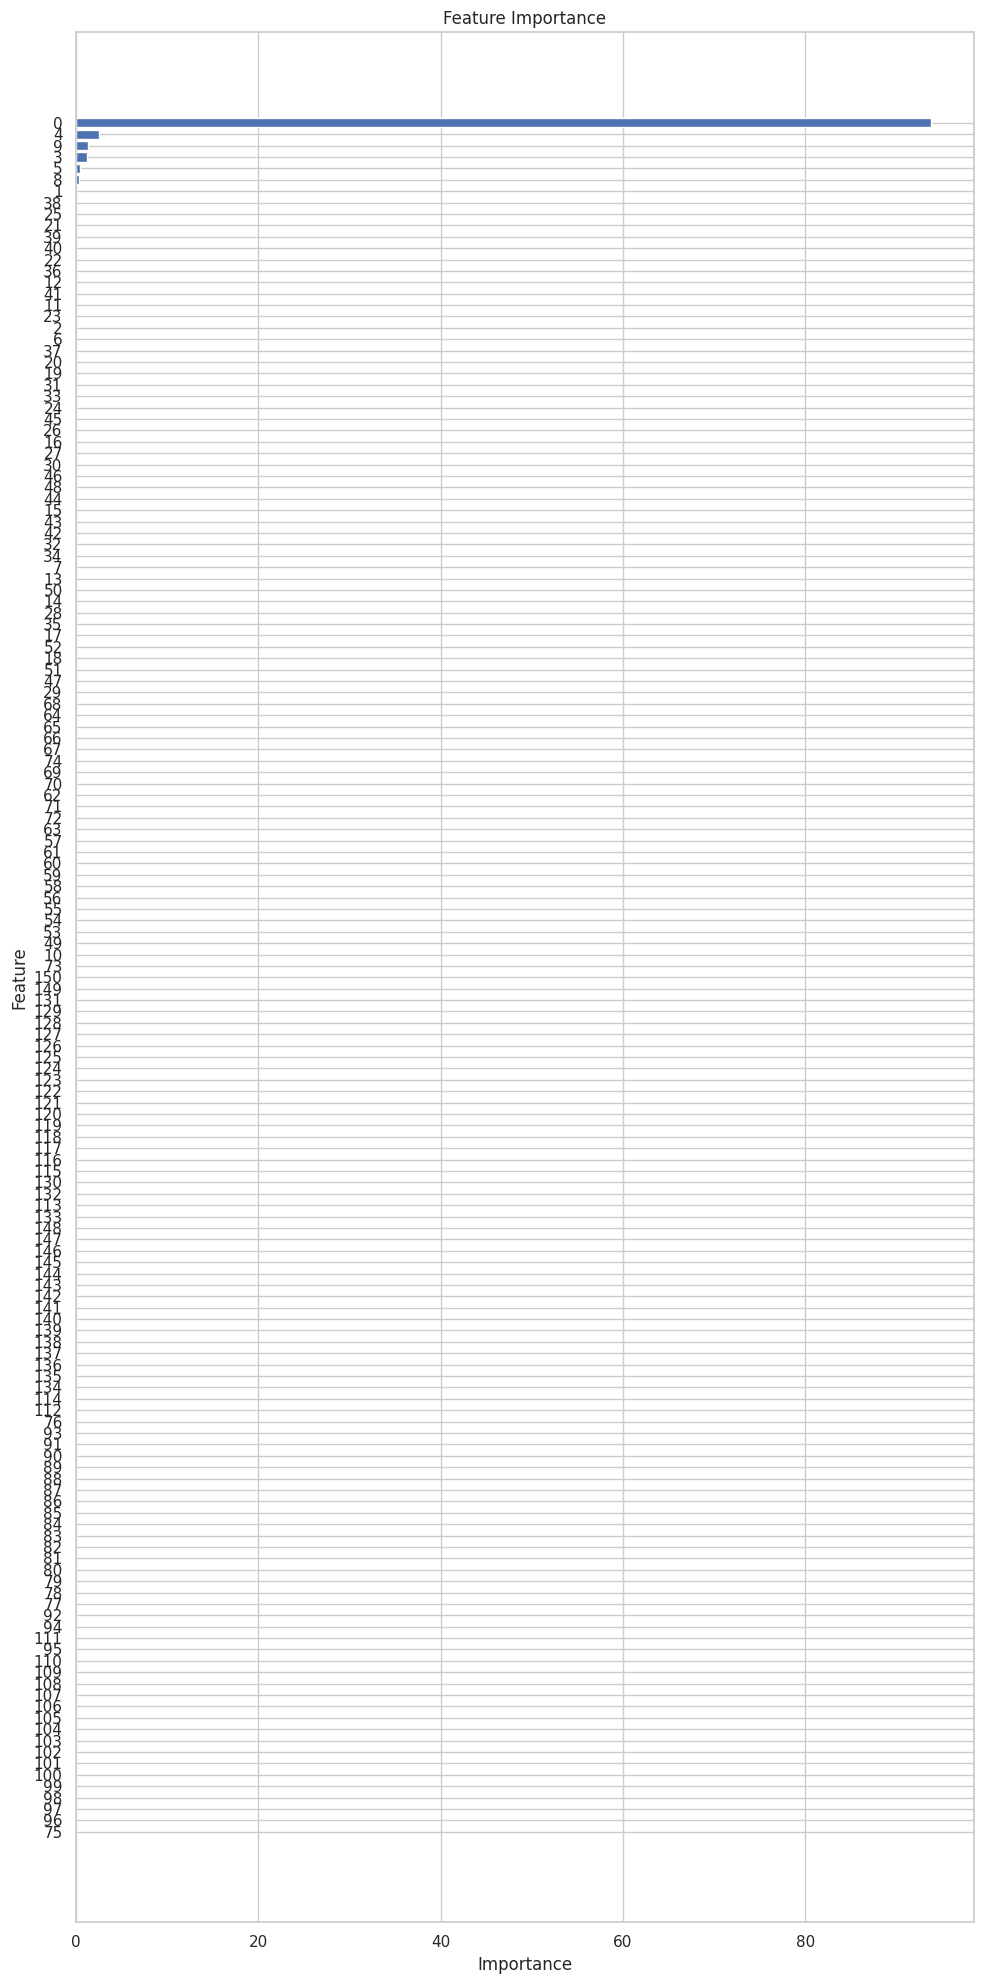

In [ ]:
feature_importances = catboost_model.get_feature_importance()

sorted_idx = np.argsort(feature_importances)[::]

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(pd.DataFrame(X).columns)[sorted_idx])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.tight_layout() # Adjust layout to fit feature names
plt.show()

In [ ]:
cutoff = 0.05
significant_features = X.columns[feature_importances > cutoff]
X_copy = X[significant_features]

In [ ]:
X.shape

(20006, 151)

In [ ]:
X_copy.shape

(20006, 6)

In [ ]:
df_test_2 = pd.DataFrame(df_test_2)

In [ ]:
df_test_2_copy = df_test_2.copy()
df_test_2_copy = df_test_2_copy[significant_features]

In [ ]:
df_test_2_copy.shape

(11040, 6)

In [ ]:
X_copy.head()

,0,3,4,5,8,9
0,0.0,3.03,1.726667,1.04,1.50,1.055556
1,85.0,2.48,2.184546,1.35,1.00,1.000000
2,8.0,4.03,2.893333,1.27,1.50,1.166667
3,20.0,3.24,2.193750,1.27,1.25,1.062500
4,54.0,2.80,1.502857,1.13,1.00,1.000000


In [ ]:
df_test_2_copy.head()

,0,3,4,5,8,9
0,0.0,3.02,1.980000,1.06,2.00,1.115385
1,0.0,2.34,1.541429,1.04,1.00,1.000000
2,0.0,3.00,2.010769,1.08,1.50,1.096154
3,0.0,3.14,1.860833,1.06,1.25,1.020833
4,0.0,2.41,1.634286,1.06,1.25,1.035714


#####Cross Validation (Same Filters Throughout)

In [ ]:
folds = 10


best_hyperparameters= {
 'l2_leaf_reg': 0.7456962724418824,
 'max_bin': 419,
 'learning_rate': 0.09167898059457538,
 'max_depth': 7,
 'random_state': 95,
 'min_data_in_leaf': 59,
 'rsm' : 0.6
 }
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X_copy, y, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

Fold 1: RMSE = 0.5740379482027548
Fold 2: RMSE = 0.6127982464636075
Fold 3: RMSE = 0.5193596176808639
Fold 4: RMSE = 0.5621019103394118
Fold 5: RMSE = 0.5715377047184643
Fold 6: RMSE = 0.571610700403492
Fold 7: RMSE = 0.5659724443075616
Fold 8: RMSE = 0.5640371374527635
Fold 9: RMSE = 0.5660655429816086
Fold 10: RMSE = 0.5322424187599358

Mean RMSE across folds: 0.5639763671310465


####Cross-Validation (Different Filters Throughout)


In [ ]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [ ]:
folds = 10


best_hyperparameters= {
 'l2_leaf_reg': 0.7456962724418824,
 'max_bin': 419,
 'learning_rate': 0.09167898059457538,
 'max_depth': 7,
 'random_state': 95,
 'min_data_in_leaf': 59,
 'rsm' : 0.6
 }
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

rmse_scores = []

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with 10 folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the CatBoost model on the training set
    catboost_model.fit(X_train, y_train, verbose=0)
    # Get the Feature Importances
    feature_importances = catboost_model.get_feature_importance()

    # Remove the Insignificant Features
    cutoff = 0.05
    significant_features = X_train.columns[feature_importances > cutoff]
    X_train_copy = X_train[significant_features]

    X_test_copy = X_test.copy()
    X_test_copy = X_test_copy[significant_features]

    # Fit the CatBoost model on the new training set
    catboost_model.fit(X_train_copy, y_train, verbose=0)

    # Evaluate the model on the validation set
    y_pred = catboost_model.predict(X_test_copy)
    rmse_score = rmse(y_test, y_pred)

    rmse_scores.append(rmse_score)

    print(f"RMSE on Validation Set: {rmse_score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

RMSE on Validation Set: 0.5740379482027548
RMSE on Validation Set: 0.6127982464636075
RMSE on Validation Set: 0.5193596176808639
RMSE on Validation Set: 0.5621019103394118
RMSE on Validation Set: 0.5715377047184643
RMSE on Validation Set: 0.571610700403492
RMSE on Validation Set: 0.5659724443075616
RMSE on Validation Set: 0.5640371374527635
RMSE on Validation Set: 0.5660655429816086
RMSE on Validation Set: 0.5322424187599358

Mean RMSE across folds: 0.5639763671310465


###Both Outliers Handling and Feature Selection **(Optional)** (Only Run 1 SubHeader, not Both)

In [275]:
from sklearn.cluster import DBSCAN

####For 1 Try

#####The Outliers Splitting

In [280]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.shape, y.shape

((20006, 151), (20006, 1))

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,0.0,9.0,0.990667,3.03,1.726667,1.04,0.913333,0.0,1.50,1.055556,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
1,85.0,11.0,0.990667,2.48,2.184546,1.35,0.913333,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
2,8.0,6.0,0.990667,4.03,2.893333,1.27,0.920000,0.0,1.50,1.166667,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
3,20.0,8.0,0.990667,3.24,2.193750,1.27,0.920000,0.0,1.25,1.062500,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
4,54.0,7.0,0.990667,2.80,1.502857,1.13,0.913333,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053


In [ ]:
from sklearn.cluster import DBSCAN

y = y.rename(columns={0: 'resp'})

df_combined = pd.concat([X, y], axis=1)

In [ ]:
df_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,resp
0,0.0,9.0,0.990667,3.03,1.726667,1.04,0.913333,0.0,1.50,1.055556,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,16.555556
1,85.0,11.0,0.990667,2.48,2.184546,1.35,0.913333,0.0,1.00,1.000000,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,28.227273
2,8.0,6.0,0.990667,4.03,2.893333,1.27,0.920000,0.0,1.50,1.166667,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,23.250000
3,20.0,8.0,0.990667,3.24,2.193750,1.27,0.920000,0.0,1.25,1.062500,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,22.250000
4,54.0,7.0,0.990667,2.80,1.502857,1.13,0.913333,0.0,1.00,1.000000,...,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053,12.785714


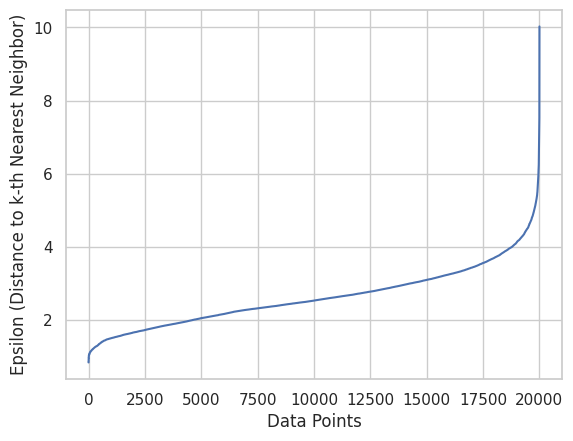

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming X is your feature matrix
neighbors = NearestNeighbors(n_neighbors=2)
distances, indices = neighbors.fit(X).kneighbors(X)

distances = distances[:, 1]
distances = np.sort(distances, axis=0)

plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Epsilon (Distance to k-th Nearest Neighbor)')
plt.show()

In [ ]:
dbscan = DBSCAN(eps=3, min_samples=5)
df_combined.columns = df_combined.columns.astype(str)
df_combined['cluster_label'] = dbscan.fit_predict(df_combined)

In [ ]:
# Extract outliers (points with cluster_label == -1)
outliers_combined = df_combined[df_combined['cluster_label'] == -1]

In [ ]:
#The Outliers
outliers_combined.drop(['cluster_label'], axis=1, inplace=True)
X_outliers = outliers_combined.iloc[:, :-2]
y_outliers = outliers_combined.iloc[:, -1]

In [ ]:
# Without Outliers
df_no_outliers_combined = df_combined[df_combined['cluster_label'] != -1]
df_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)

In [ ]:
X_no_outliers = df_no_outliers_combined.iloc[:, :-1]
y_no_outliers = df_no_outliers_combined.iloc[:, -1]

In [ ]:
X_no_outliers.shape, y_no_outliers.shape, X.shape, y.shape

((2232, 151), (2232,), (20006, 151), (20006, 1))

In [ ]:
X_no_outliers.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
36,67.0,5.0,0.990667,3.35,2.724000,0.74,0.918,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
99,66.0,4.0,0.957500,3.44,2.312500,1.11,0.925,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
136,31.0,12.0,0.957500,3.30,2.146667,0.76,0.925,0.0,1.25,1.020833,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
185,68.0,6.0,0.965000,3.24,2.381667,1.40,0.930,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053
186,29.0,8.0,0.967500,2.37,1.182500,0.54,0.920,0.0,1.00,1.000000,...,3.077003,3.079737,3.060849,2.987949,3.061061,3.037048,3.039934,3.036791,3.058066,3.049053


In [ ]:
y_no_outliers.head()

36      6.700000
99      6.125000
136    30.625000
185     6.333333
186    27.062500
Name: resp, dtype: float64

#####Fitting For Feature Selection

In [ ]:
best_hyperparameters= {
  'l2_leaf_reg': 0.7456962724418824,
 'max_bin': 419,
 'learning_rate': 0.09167898059457538,
 'max_depth': 7,
 'random_state': 95,
 'min_data_in_leaf': 59,
 'rsm' : 0.6
 }

catboost_model = CatBoostRegressor(**best_hyperparameters)
catboost_model.fit(X_no_outliers, y_no_outliers, verbose=0)

#####The Filtering (Feature Selection)

In [ ]:
X_no_outliers = pd.DataFrame(X_no_outliers)

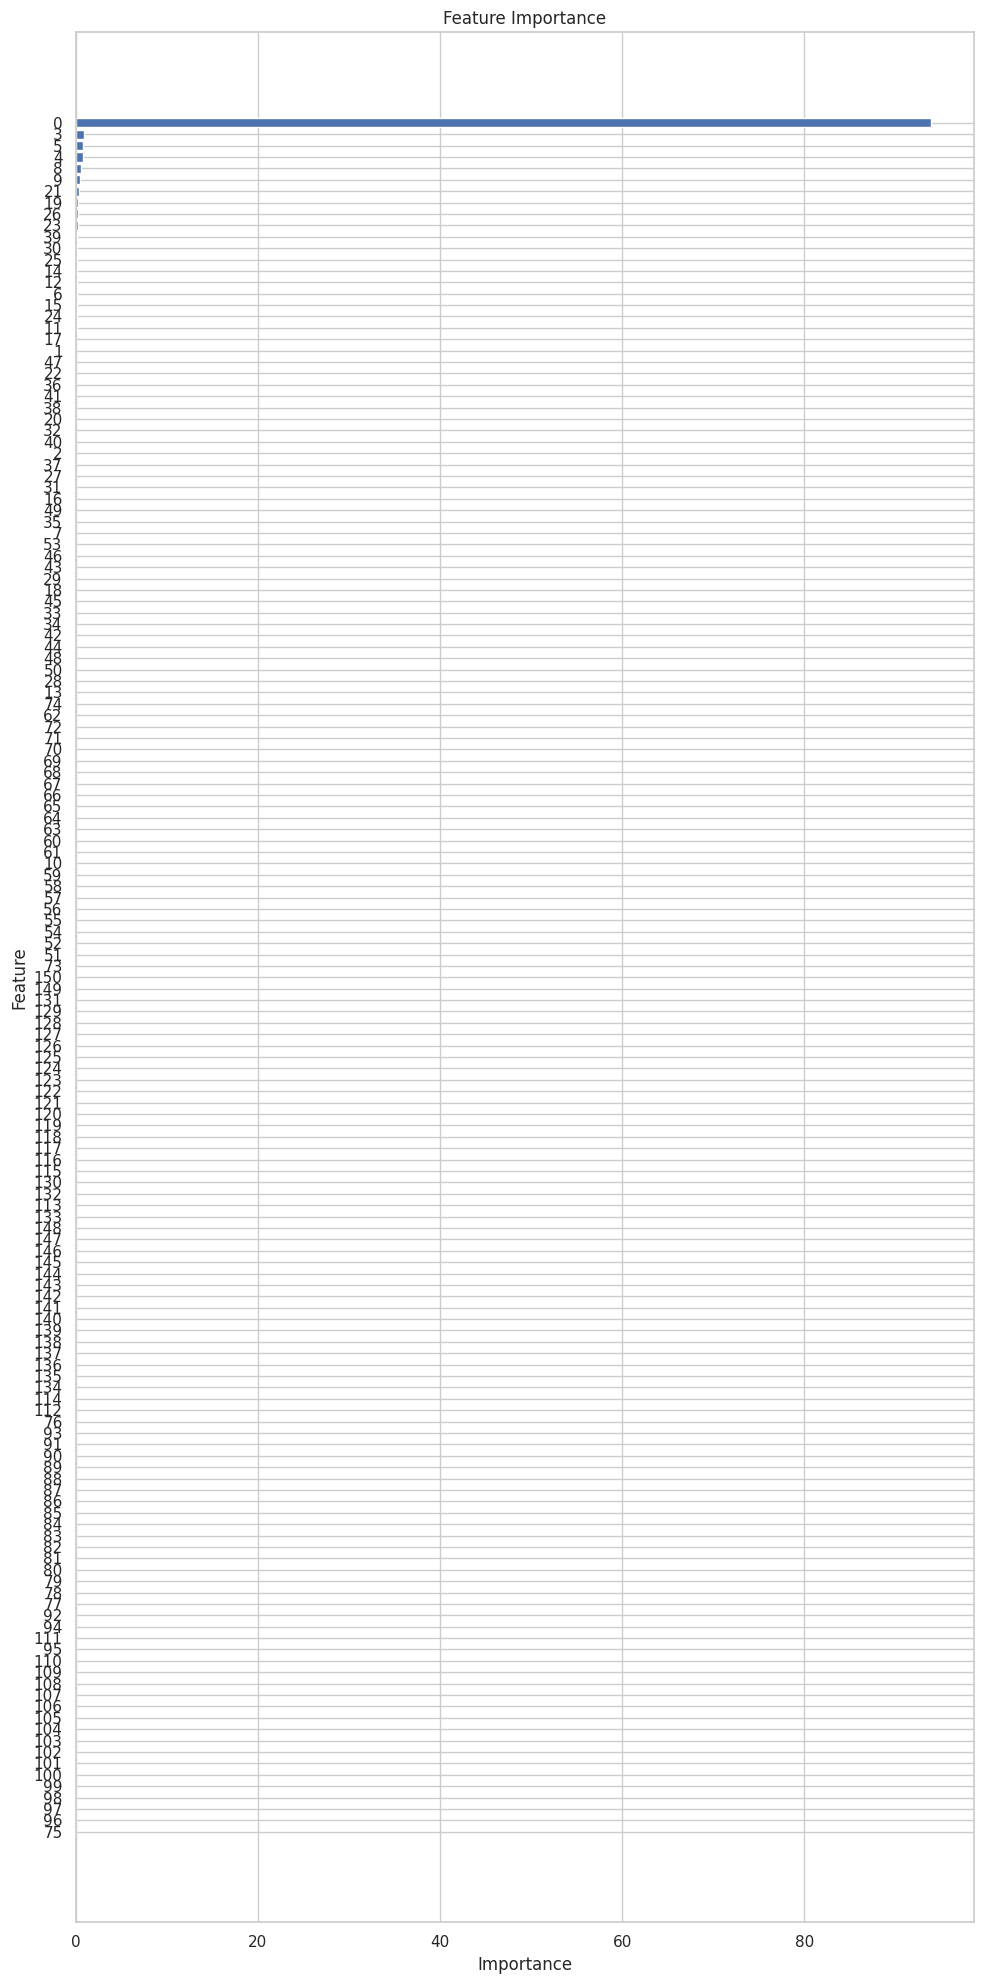

In [ ]:
feature_importances = catboost_model.get_feature_importance()

sorted_idx = np.argsort(feature_importances)[::]

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(pd.DataFrame(X_no_outliers).columns)[sorted_idx])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.tight_layout() # Adjust layout to fit feature names
plt.show()

In [ ]:
cutoff = 0.05
significant_features = X_no_outliers.columns[feature_importances > cutoff]
X_copy = X_no_outliers[significant_features]

In [ ]:
X_no_outliers.shape

(2232, 151)

In [ ]:
X_copy.shape

(2232, 21)

In [ ]:
df_test_2 = pd.DataFrame(df_test_2)

In [ ]:
df_test_2.columns = df_test_2.columns.astype(str)
df_test_2_copy = df_test_2.copy()
df_test_2_copy = df_test_2_copy[significant_features]

In [ ]:
df_test_2_copy.shape

(11040, 21)

In [ ]:
X_copy.head()

,0,1,3,4,5,6,8,9,11,12,...,15,17,19,21,23,24,25,26,30,39
36,67.0,5.0,3.35,2.724000,0.74,0.918,1.00,1.000000,40.614666,1.3960,...,-0.848644,0.0,1.000000,1.000000,1.000000,6.123234e-17,1.00,0.0,0.0,2.724000
99,66.0,4.0,3.44,2.312500,1.11,0.925,1.00,1.000000,41.240002,1.8975,...,-0.848644,0.0,0.965926,1.000000,0.965926,-2.588190e-01,1.00,0.0,0.0,2.233703
136,31.0,12.0,3.30,2.146667,0.76,0.925,1.25,1.020833,41.157501,1.8775,...,-0.848644,0.0,0.986049,1.020833,1.207407,-3.235238e-01,1.25,0.0,0.0,2.073521
185,68.0,6.0,3.24,2.381667,1.40,0.930,1.00,1.000000,41.047501,1.8575,...,-0.848644,0.0,0.965926,1.000000,0.965926,-2.588190e-01,1.00,0.0,0.0,2.300513
186,29.0,8.0,2.37,1.182500,0.54,0.920,1.00,1.000000,41.162498,1.7675,...,-0.848644,0.0,0.965926,1.000000,0.965926,-2.588190e-01,1.00,0.0,0.0,1.142207


In [ ]:
df_test_2_copy.head()

,0,1,3,4,5,6,8,9,11,12,...,15,17,19,21,23,24,25,26,30,39
0,0.0,13.0,3.02,1.980000,1.06,0.68,2.00,1.115385,29.930000,1.99,...,0.299363,-0.433884,0.000000,-1.004927,0.000000,2.000000,-1.801938,-0.867767,-0.433884,0.000000
1,0.0,14.0,2.34,1.541429,1.04,0.68,1.00,1.000000,30.190001,2.35,...,0.299363,-0.433884,0.258819,-0.900969,0.258819,0.965926,-0.900969,-0.433884,-0.433884,0.398951
2,0.0,13.0,3.00,2.010769,1.08,0.69,1.50,1.096154,30.020000,1.98,...,0.299363,-0.433884,0.548077,-0.987601,0.750000,1.299038,-1.351453,-0.650826,-0.433884,1.005385
3,0.0,12.0,3.14,1.860833,1.06,0.70,1.25,1.020833,29.889999,1.92,...,0.299363,-0.433884,0.721838,-0.919739,0.883883,0.883883,-1.126211,-0.542355,-0.433884,1.315808
4,0.0,7.0,2.41,1.634286,1.06,0.71,1.25,1.035714,29.920000,1.58,...,0.299363,-0.433884,0.896955,-0.933146,1.082532,0.625000,-1.126211,-0.542355,-0.433884,1.415333


#####Cross-Validation (Same Filters and Features Throughout)

In [ ]:
folds = 10


best_hyperparameters= {
 'l2_leaf_reg': 0.7456962724418824,
 'max_bin': 419,
 'learning_rate': 0.09167898059457538,
 'max_depth': 7,
 'random_state': 95,
 'min_data_in_leaf': 59,
 'rsm' : 0.6
 }
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X_copy, y_no_outliers, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

Fold 1: RMSE = 0.6057842771115761
Fold 2: RMSE = 0.6035710415747143
Fold 3: RMSE = 0.5740136276294228
Fold 4: RMSE = 0.5964492089425569
Fold 5: RMSE = 0.6191552878403495
Fold 6: RMSE = 0.6216751917115176
Fold 7: RMSE = 0.5670972447233342
Fold 8: RMSE = 0.5537998680712174
Fold 9: RMSE = 0.5381437775837237
Fold 10: RMSE = 0.6493831787608267

Mean RMSE across folds: 0.592907270394924


####Cross-Validation (Different Filters and Features Throughout)

In [ ]:
folds = 10
best_hyperparameters= {
 'l2_leaf_reg': 0.7456962724418824,
 'max_bin': 419,
 'learning_rate': 0.09167898059457538,
 'max_depth': 7,
 'random_state': 95,
 'min_data_in_leaf': 59,
 'rsm' : 0.6
 }
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

rmse_scores = []

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with 5 folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply DBSCAN on the training set
    df_train_combined = pd.concat([X_train, y_train], axis=1)
    dbscan = DBSCAN(eps=7, min_samples=5)
    df_train_combined.columns = df_train_combined.columns.astype(str)
    df_train_combined['cluster_label'] = dbscan.fit_predict(df_train_combined)

    # Without Outliers in the training set
    df_train_no_outliers_combined = df_train_combined[df_train_combined['cluster_label'] != -1]
    df_train_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)
    X_train_no_outliers = df_train_no_outliers_combined.iloc[:, :-1]
    y_train_no_outliers = df_train_no_outliers_combined.iloc[:, -1]

    # Fit the CatBoost model on the training set without outliers
    catboost_model.fit(X_train_no_outliers, y_train_no_outliers, verbose=0)
    # Get the Feature Importances
    feature_importances = catboost_model.get_feature_importance()

    # Remove the Insignificant Features
    cutoff = 0.05
    significant_features = X_train.columns[feature_importances > cutoff]
    X_train_copy = X_train[significant_features]

    X_test_copy = X_test.copy()
    X_test_copy = X_test_copy[significant_features]

    # Fit the CatBoost model on the new training set
    catboost_model.fit(X_train_copy, y_train, verbose=0)

    # Evaluate the model on the validation set
    y_pred = catboost_model.predict(X_test_copy)
    rmse_score = rmse(y_test, y_pred)

    rmse_scores.append(rmse_score)

    print(f"RMSE on Validation Set: {rmse_score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

RMSE on Validation Set: 0.5740379482027548
RMSE on Validation Set: 0.6127982464636075
RMSE on Validation Set: 0.5193596176808639
RMSE on Validation Set: 0.5621019103394118
RMSE on Validation Set: 0.5715377047184643
RMSE on Validation Set: 0.571610700403492
RMSE on Validation Set: 0.5659724443075616
RMSE on Validation Set: 0.5640371374527635
RMSE on Validation Set: 0.5660655429816086
RMSE on Validation Set: 0.5322424187599358

Mean RMSE across folds: 0.5639763671310465


###Manual Columns Filtering

In [557]:
X=pd.DataFrame(X)

In [558]:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

  best_hyperparameters =   {'l2_leaf_reg': 1.8830862508539454,
                         'max_bin': 506,
                         'learning_rate': 0.03154760539251062,
                         'iterations': 21313,
                         'max_depth': 4,
                         'random_state': 69,
                         'min_data_in_leaf': 121,
                         'rsm': 0.6}
  catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

  # Fit the CatBoost model on the training set without outliers
  catboost_model.fit(X_train, y_train, verbose=0)
  # Get the Feature Importances
  feature_importances = catboost_model.get_feature_importance()

  # Remove the Insignificant Features
  cutoff = 0.065
  significant_features = X_train.columns[feature_importances > cutoff]
  X_train_copy = X_train[significant_features]

  X_test_copy = X_test.copy()
  X_test_copy = X_test_copy[significant_features]

  # Fit the CatBoost model on the new training set
  catboost_model.fit(X_train_copy, y_train, verbose=0)

  # Evaluate the model on the validation set
  y_pred = catboost_model.predict(X_test_copy)
  rmse_score = mean_squared_error(y_test, y_pred, squared=False)


  print(rmse_score)

0.592520189358314


In [560]:
X_train_copy.columns

Int64Index([0, 3, 4, 5, 8, 9], dtype='int64')

In [562]:
df_test_2=pd.DataFrame(df_test_2)
df_test_2.columns

RangeIndex(start=0, stop=151, step=1)

In [563]:
X_copy2 = X.copy()
X_copy2 = X_copy2[X_train_copy.columns]

In [564]:
df_test_2.columns = df_test_2.columns.astype('int64')
df_test_2.columns

RangeIndex(start=0, stop=151, step=1)

In [565]:
df_test_2 = pd.DataFrame(df_test_2)
df_test_2_copy = df_test_2.copy()
df_test_2_copy = df_test_2_copy[X_train_copy.columns]

In [566]:
df_test_2_copy

,0,3,4,5,8,9
0,0.0,3.02,1.980000,1.06,2.00,1.115385
1,0.0,2.34,1.541429,1.04,1.00,1.000000
2,0.0,3.00,2.010769,1.08,1.50,1.096154
3,0.0,3.14,1.860833,1.06,1.25,1.020833
4,0.0,2.41,1.634286,1.06,1.25,1.035714
...,...,...,...,...,...,...
11035,95.0,3.08,2.024545,0.72,1.00,1.000000
11036,95.0,3.20,2.002500,0.72,1.00,1.000000
11037,95.0,3.08,2.105714,0.72,1.00,1.000000
11038,95.0,3.20,1.952500,0.72,1.00,1.000000


In [ ]:
''''
best_hyperparameters= {
    'l2_leaf_reg': 0.7456962724418824,
    'max_bin': 419,
    'learning_rate': 0.09167898059457538,
    'max_depth': 7,
    'random_state': 95,
    'min_data_in_leaf': 59,
    'rsm' : 0.6
 }

'''

---
Ini yang dipake ya ges

In [567]:
folds = 10

best_hyperparameters =   {'l2_leaf_reg': 1.8830862508539454,
                         'max_bin': 506,
                         'learning_rate': 0.03154760539251062,
                         'iterations': 21313,
                         'max_depth': 4,
                         'random_state': 69,
                         'min_data_in_leaf': 121,
                         'rsm': 0.6}
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X_copy2, y, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

Fold 1: RMSE = 0.5722700674130099
Fold 2: RMSE = 0.6030551337904232
Fold 3: RMSE = 0.5166088453187468
Fold 4: RMSE = 0.5528118030532961
Fold 5: RMSE = 0.578600643685127
Fold 6: RMSE = 0.5724351596939737
Fold 7: RMSE = 0.5574036842600962
Fold 8: RMSE = 0.549832756945416
Fold 9: RMSE = 0.5589996912524111
Fold 10: RMSE = 0.5319915424374988

Mean RMSE across folds: 0.5594009327849998


###Permanent Changing of Data Test **(Alert)**
---
Changing in respect of the columns considered not significant by feature selection and rows from outliers handling

In [568]:
try:
  X = X_copy2
except:
  X = X_copy

In [569]:
df_test_2 = df_test_2_copy

###Predicting to Submit

In [570]:
best_hyperparameters =   {'l2_leaf_reg': 1.8830862508539454,
                         'max_bin': 506,
                         'learning_rate': 0.03154760539251062,
                         'iterations': 21313,
                         'max_depth': 4,
                         'random_state': 69,
                         'min_data_in_leaf': 121,
                         'rsm': 0.6}
catboost_model = CatBoostRegressor(**best_hyperparameters)
catboost_model.fit(X, y, verbose=0)

In [571]:
catboost_model.predict(df_test_2)

array([18.73426287, 14.64366125, 18.36633771, ..., 29.75330342,
       29.38611417, 31.30265986])

In [572]:
df_test_2.shape, X2.shape

index = np.arange(0, 11040)
price_mean = catboost_model.predict(df_test_2)

submission = pd.DataFrame({'index': index, 'price_mean': price_mean})
submission.head()

,index,price_mean
0,0,18.734263
1,1,14.643661
2,2,18.366338
3,3,16.232930
4,4,15.549112


In [573]:
from sklearn.metrics import mean_squared_error

df_to_check = pd.read_csv("/content/submission2-20-11-23-catboost-Jes.csv")
df_to_check.head(3)

,index,price_mean
0,0,18.493562
1,1,14.737193
2,2,18.459363


In [574]:
y_true = df_to_check['price_mean']
y_pred = submission['price_mean']
mean_squared_error(y_true, y_pred) ** (0.5)

0.14162092738731658

In [575]:
submission.to_csv('submission1-20-11-23-catboost-Adriaan.csv', index=False)

In [576]:
import pickle
filename = 'catboost3-20-11.pkl'
pickle.dump(catboost_model, open(filename, 'wb'))

In [578]:
y=pd.DataFrame(y)
X=pd.DataFrame(X)

In [579]:
# simpen df train
data = np.concatenate((X, y.values.reshape(-1, 1)), axis=1)
data = pd.DataFrame(data)
data.to_csv('df_train_submission-20-11.csv', index=False)

In [580]:
# simpen df test
data = pd.DataFrame(df_test_2)
data.to_csv('df_test_submission-20-11.csv', index=False)